# DS-UA 202 Responsible Data Science, Spring 2023
# Course Project: Technical Audit of an Automated Decision System
# Credit Card Default Prediction System Fairness Evaluation

# Chang Li (cl5034) & Fengfei Niu (fn567)

# Introduction

Every bank experiences losses due to credit card defaults. If we have a good idea of who will default, we can do something to try to prevent it (forebearance, consulting, etc.). <br>
This project replicates a solution from Medium that tries to predict credit card defaults, and evaluates its fairness based on performance across sensitive features. The solution is adapted from here: https://medium.com/swlh/predicting-credit-card-defaults-with-machine-learning-fcc8da2fdafb

## Target

Default payment (Yes=1, No=0)

## Features

limit_bal: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit

sex: Gender (1 = male; 2 = female)

Education (1 = graduate school; 2 = university; 3 = high school; 4 = others)

Marital status (1 = married; 2 = single; 3 = others)

Age (year)

History of past payment. (UCI) tracked the past monthly payment records (from April to September, 2005) as follows: The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above

Amount of bill statement (NT dollar) from April to September, 2005

Amount of previous payment (NT dollar) from April to September 2005

# Import Libraries



In [ ]:
# For data manipulation
import pandas as pd
import numpy as np
import pickle

# Data visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
# %config InlineBackend.figure_formats = ['svg']
# sns.set(style='white', palette = 'Paired')

# Modeling
from sklearn.inspection import permutation_importance
from sklearn import linear_model, svm, naive_bayes, neighbors, ensemble
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, fbeta_score, recall_score, precision_recall_fscore_support

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier, VotingClassifier, 
                              AdaBoostClassifier, BaggingRegressor)
from sklearn.metrics import accuracy_score, make_scorer, log_loss

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from mlxtend.plotting import plot_decision_regions

import xgboost as xgb

from IPython.display import clear_output

In [ ]:
!sudo apt install libcairo2-dev pkg-config python3-dev
!pip install aequitas
clear_output()

In [ ]:
from aequitas.group import Group
from aequitas.bias import Bias
from aequitas.fairness import Fairness
from aequitas.plotting import Plot

In [ ]:
!pip install shap
import shap
import operator
from collections import defaultdict
shap.initjs()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Import Dataset

In [ ]:
df = pd.read_excel('https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls', header = 1)
df

ID  LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  \
0          1      20000    2          2         1   24      2      2     -1   
1          2     120000    2          2         2   26     -1      2      0   
2          3      90000    2          2         2   34      0      0      0   
3          4      50000    2          2         1   37      0      0      0   
4          5      50000    1          2         1   57     -1      0     -1   
...      ...        ...  ...        ...       ...  ...    ...    ...    ...   
29995  29996     220000    1          3         1   39      0      0      0   
29996  29997     150000    1          3         2   43     -1     -1     -1   
29997  29998      30000    1          2         2   37      4      3      2   
29998  29999      80000    1          3         1   41      1     -1      0   
29999  30000      50000    1          2         1   46      0      0      0   

       PAY_4  ...  BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  PAY_AMT2  \
0         -1  ...          0          0          0         0       689   
1          0  ...       3272       3455       3261         0      1000   
2          0  ...      14331      14948      15549      1518      1500   
3          0  ...      28314      28959      29547      2000      2019   
4          0  ...      20940      19146      19131      2000     36681   
...      ...  ...        ...        ...        ...       ...       ...   
29995      0  ...      88004      31237      15980      8500     20000   
29996     -1  ...       8979       5190          0      1837      3526   
29997     -1  ...      20878      20582      19357         0         0   
29998      0  ...      52774      11855      48944     85900      3409   
29999      0  ...      36535      32428      15313      2078      1800   

       PAY_AMT3  PAY_AMT4  PAY_AMT5  PAY_AMT6  default payment next month  
0             0         0         0         0                           1  
1          1000      1000         0      2000                           1  
2          1000      1000      1000      5000                           0  
3          1200      1100      1069      1000                           0  
4         10000      9000       689       679                           0  
...         ...       ...       ...       ...                         ...  
29995      5003      3047      5000      1000                           0  
29996      8998       129         0         0                           0  
29997     22000      4200      2000      3100                           1  
29998      1178      1926     52964      1804                           1  
29999      1430      1000      1000      1000                           1  

[30000 rows x 25 columns]

In [ ]:
print(df.isnull().values.sum())

0


# Solution From Medium

## Data Preprocessing

In [ ]:
# The column names are a little odd, so let's change them
column_names = {
    'history_names': {
        'PAY_0':'Sep_Hist','PAY_6':'Aug_Hist','PAY_2':'Jul_Hist',
        'PAY_3':'Jun_Hist','PAY_4':'May_Hist','PAY_5':'Apr_Hist'
    },
    'balance_names': {
        'BILL_AMT1':'Sep_Bal','BILL_AMT2':'Aug_Bal','BILL_AMT3':'Jul_Bal',
        'BILL_AMT4':'Jun_Bal','BILL_AMT5':'May_Bal','BILL_AMT6':'Apr_Bal'
    },
    'payment_names': {
        'PAY_AMT1':'Sep_Pmt','PAY_AMT2':'Aug_Pmt','PAY_AMT3':'Jul_Pmt',
        'PAY_AMT4':'Jun_Pmt','PAY_AMT5':'May_Pmt','PAY_AMT6':'Apr_Pmt'
    }
}

for column_name in column_names:
    df.rename(columns=column_names[column_name], inplace=True)

df.rename(columns={'default payment next month': 'Default'}, inplace=True)

In [ ]:
# ID column is just an identifier, which also has no predictive value. So we remove.
df.drop(['ID'], axis=1, inplace=True)

In [ ]:
# Sex, education, and marriage should be categorical columns
df['SEX'].replace(to_replace=[1, 2], value=['male', 'female'], inplace=True)

df['EDUCATION'].replace(to_replace=[1, 2, 3, 4, 6, 0],
                        value=['graduate', 'university', 'highschool', 'other', 'other', 'other'],
                        inplace=True)

df['MARRIAGE'].replace(to_replace=[1, 2, 3, 0], value=['married', 'single', 'other', 'other'], inplace=True)

In [ ]:
# Let's take a look at the range of values for payment history
payment_months = ['Sep_Hist', 'Aug_Hist', 'Jul_Hist',
                  'Jun_Hist', 'May_Hist', 'Apr_Hist']

for month in payment_months:
    print(sorted(df[month].unique()))

[-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8]
[-2, -1, 0, 2, 3, 4, 5, 6, 7, 8]
[-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8]
[-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8]
[-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8]
[-2, -1, 0, 2, 3, 4, 5, 6, 7, 8]


In [ ]:
# These ranges are pretty odd, let's change the range to 0-10, which is more reasonable
old_range = [-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8]
new_range = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

for month in payment_months:
    df[month].replace(to_replace=old_range,
                      value=new_range,
                      inplace=True)

In [ ]:
df.rename(columns = {'LIMIT_BAL':'limit_bal', 'SEX':'sex', 'EDUCATION':'education', 'MARRIAGE':'marriage', 'AGE':'age'}, inplace = True)

In [ ]:
df

limit_bal     sex   education marriage  age  Sep_Hist  Jul_Hist  \
0          20000  female  university  married   24         4         4   
1         120000  female  university   single   26         1         4   
2          90000  female  university   single   34         2         2   
3          50000  female  university  married   37         2         2   
4          50000    male  university  married   57         1         2   
...          ...     ...         ...      ...  ...       ...       ...   
29995     220000    male  highschool  married   39         2         2   
29996     150000    male  highschool   single   43         1         1   
29997      30000    male  university   single   37         6         5   
29998      80000    male  highschool  married   41         3         1   
29999      50000    male  university  married   46         2         2   

       Jun_Hist  May_Hist  Apr_Hist  ...  Jun_Bal  May_Bal  Apr_Bal  Sep_Pmt  \
0             1         1         0  ...        0        0        0        0   
1             2         2         2  ...     3272     3455     3261        0   
2             2         2         2  ...    14331    14948    15549     1518   
3             2         2         2  ...    28314    28959    29547     2000   
4             1         2         2  ...    20940    19146    19131     2000   
...         ...       ...       ...  ...      ...      ...      ...      ...   
29995         2         2         2  ...    88004    31237    15980     8500   
29996         1         1         2  ...     8979     5190        0     1837   
29997         4         1         2  ...    20878    20582    19357        0   
29998         2         2         2  ...    52774    11855    48944    85900   
29999         2         2         2  ...    36535    32428    15313     2078   

       Aug_Pmt  Jul_Pmt  Jun_Pmt  May_Pmt  Apr_Pmt  Default  
0          689        0        0        0        0        1  
1         1000     1000     1000        0     2000        1  
2         1500     1000     1000     1000     5000        0  
3         2019     1200     1100     1069     1000        0  
4        36681    10000     9000      689      679        0  
...        ...      ...      ...      ...      ...      ...  
29995    20000     5003     3047     5000     1000        0  
29996     3526     8998      129        0        0        0  
29997        0    22000     4200     2000     3100        1  
29998     3409     1178     1926    52964     1804        1  
29999     1800     1430     1000     1000     1000        1  

[30000 rows x 24 columns]

## Exploratory Analysis

In [ ]:
df.head()

limit_bal     sex   education marriage  age  Sep_Hist  Jul_Hist  Jun_Hist  \
0      20000  female  university  married   24         4         4         1   
1     120000  female  university   single   26         1         4         2   
2      90000  female  university   single   34         2         2         2   
3      50000  female  university  married   37         2         2         2   
4      50000    male  university  married   57         1         2         1   

   May_Hist  Apr_Hist  ...  Jun_Bal  May_Bal  Apr_Bal  Sep_Pmt  Aug_Pmt  \
0         1         0  ...        0        0        0        0      689   
1         2         2  ...     3272     3455     3261        0     1000   
2         2         2  ...    14331    14948    15549     1518     1500   
3         2         2  ...    28314    28959    29547     2000     2019   
4         2         2  ...    20940    19146    19131     2000    36681   

   Jul_Pmt  Jun_Pmt  May_Pmt  Apr_Pmt  Default  
0        0        0        0        0        1  
1     1000     1000        0     2000        1  
2     1000     1000     1000     5000        0  
3     1200     1100     1069     1000        0  
4    10000     9000      689      679        0  

[5 rows x 24 columns]

### Visualize Data

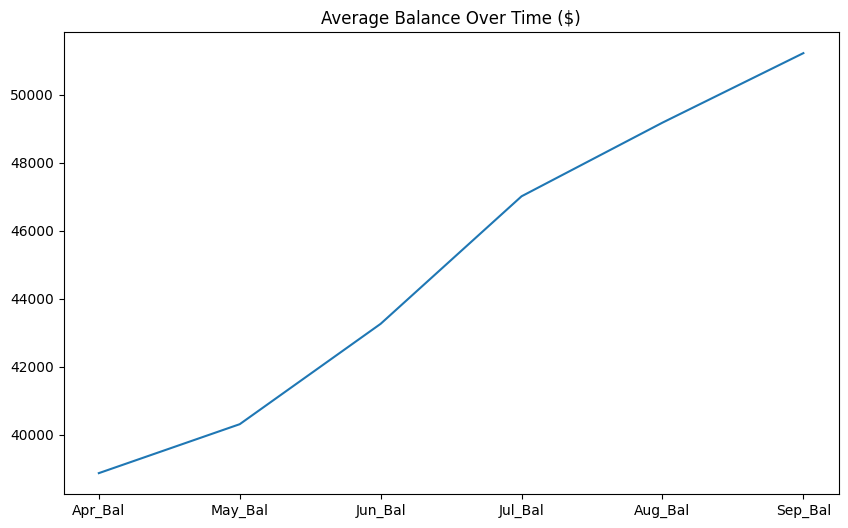

In [ ]:
# Average balance over time
bal_months = ['Apr_Bal', 'May_Bal', 'Jun_Bal',
              'Jul_Bal', 'Aug_Bal', 'Sep_Bal']
avg_bal = []

for month in bal_months:
    avg_bal.append(df[month].mean())

plt.figure(figsize=(10,6))
plt.plot(bal_months, avg_bal)
plt.title('Average Balance Over Time ($)')
plt.show();

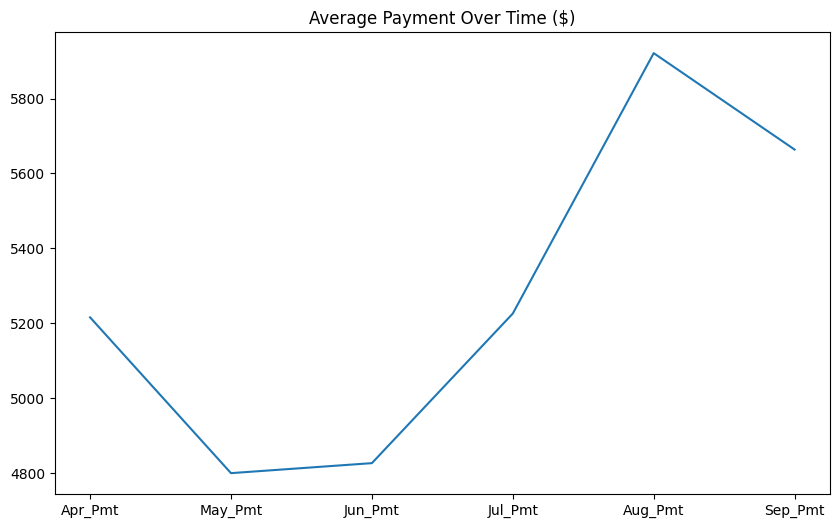

In [ ]:
# Average payment over time
monthly_payments = ['Apr_Pmt', 'May_Pmt', 'Jun_Pmt',
                    'Jul_Pmt', 'Aug_Pmt', 'Sep_Pmt']
avg_pmt = []

for month in monthly_payments:
    avg_pmt.append(df[month].mean())

plt.figure(figsize=(10,6))
plt.plot(monthly_payments, avg_pmt)
plt.title('Average Payment Over Time ($)')
plt.show();

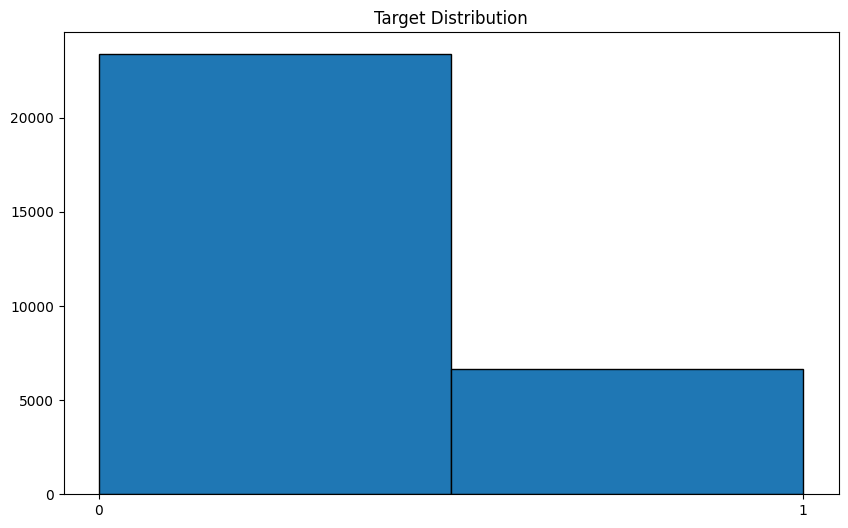

In [ ]:
# The data is highly imbalanced
plt.figure(figsize=(10,6))
plt.hist(df['Default'], bins=2, edgecolor = "black")
plt.title('Target Distribution')
plt.xticks([0,1])
plt.show();

Highly imbalanced dataset

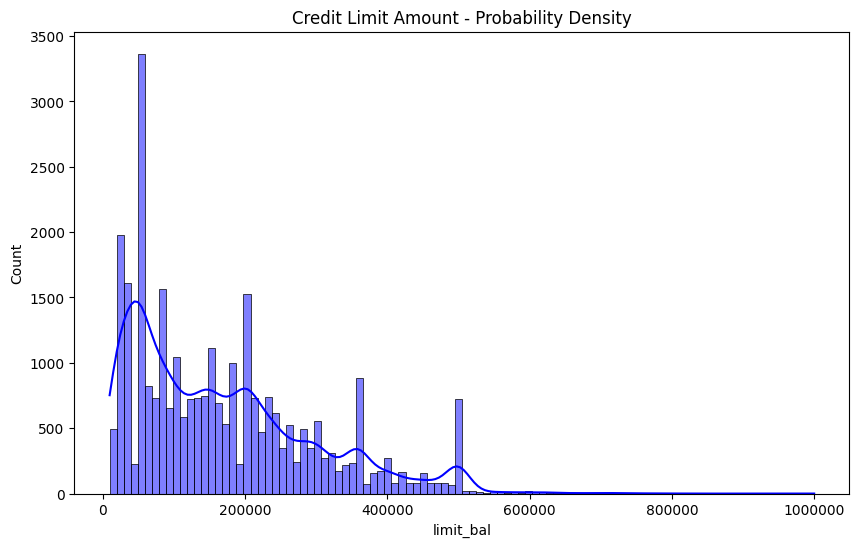

In [ ]:
# Distribution of limit balance
plt.figure(figsize = (10,6))
plt.title('Credit Limit Amount - Probability Density')
plt.ticklabel_format(style='plain', axis='x')
sns.histplot(df['limit_bal'],kde=True,bins=100, color="blue")
plt.show();

In [ ]:
# Top Credit Limit Amounts in our distribution
df['limit_bal'].value_counts().head()

50000     3365
20000     1976
30000     1610
80000     1567
200000    1528
Name: limit_bal, dtype: int64

Largest Credit Limit Amount groups are 50k, 20k, and 30k

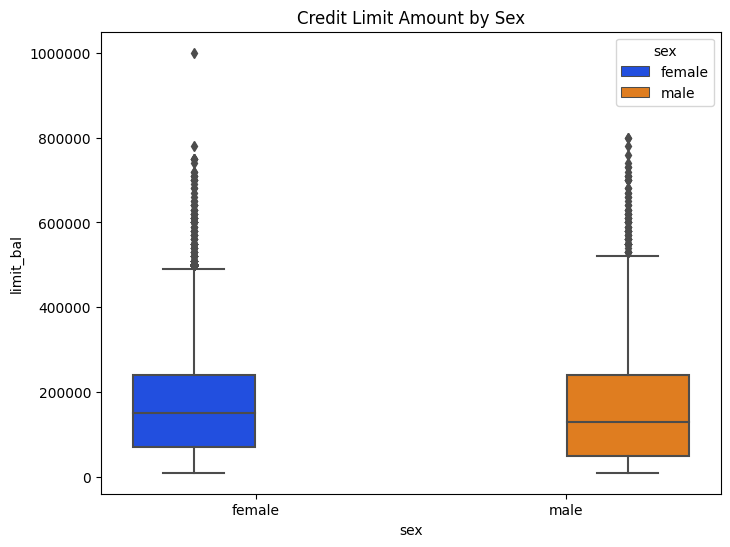

In [ ]:
# Credit Limit vs Sex
plt.figure(figsize = (8,6))
plt.title('Credit Limit Amount by Sex')
plt.ticklabel_format(style='plain', axis='y')
sns.boxplot(x='sex', y='limit_bal', hue='sex', data=df, palette='bright')
plt.show();

Credit limit amount is evenly distributed amongst males and females

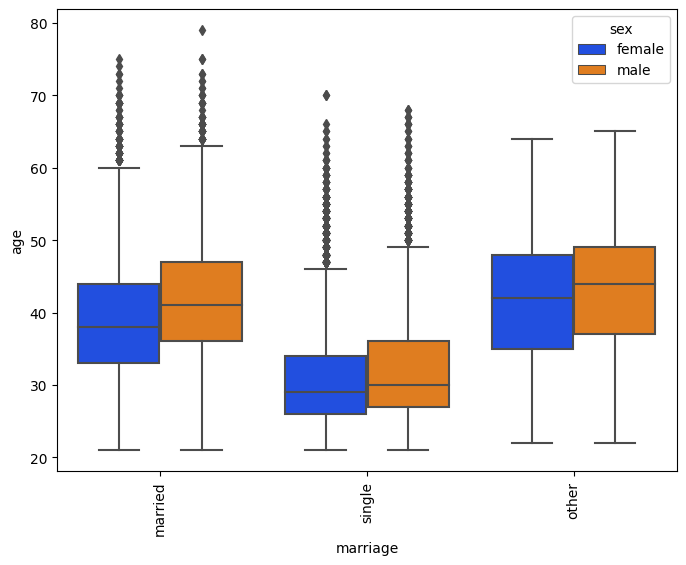

In [ ]:
# Marriage, Age, and Sex
def boxplot_variation(feature1, feature2, feature3, width=16):
    fig, ax1 = plt.subplots(ncols=1, figsize=(width, 6))
    s = sns.boxplot(ax=ax1, x=feature1, y=feature2, hue=feature3,
                    data=df, palette='bright')
    s.set_xticklabels(s.get_xticklabels(), rotation=90)
    plt.show();

boxplot_variation('marriage', 'age', 'sex', 8)

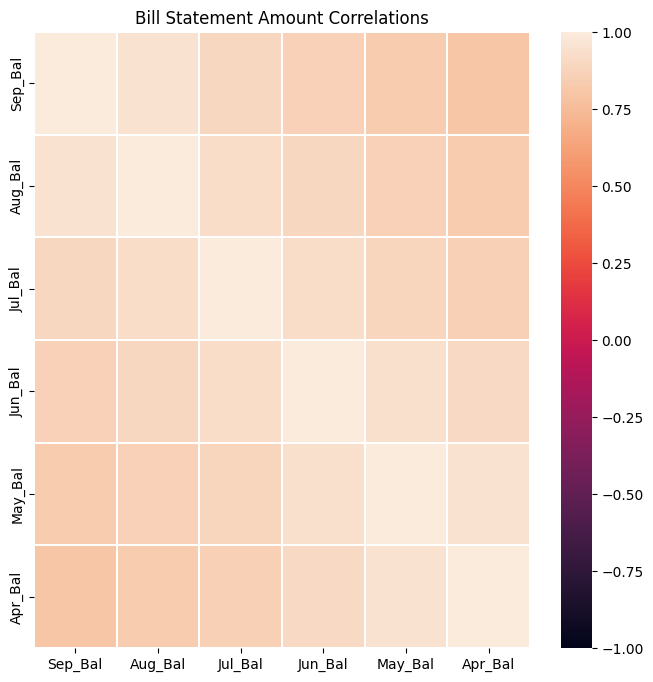

In [ ]:
# Amount of Bill Statement
# Correlation Plot
values = list(column_names['balance_names'].values())

plt.figure(figsize=(8,8))
plt.title('Bill Statement Amount Correlations')
corr = df[values].corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, linewidths=0.1, vmin=-1, vmax=1)
plt.show();

Correlation between months becomes stronger the closer the months are in time.

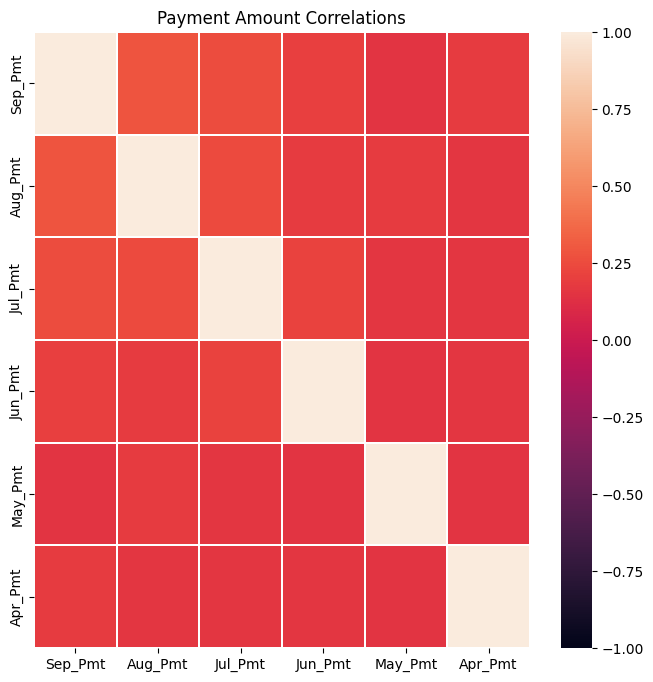

In [ ]:
# Amount of Previous Payment
# Correlation Plot
values = list(column_names['payment_names'].values())

plt.figure(figsize=(8,8))
plt.title('Payment Amount Correlations')
corr = df[values].corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, linewidths=0.1, vmin=-1, vmax=1)
plt.show();

No correlation between payment amount months

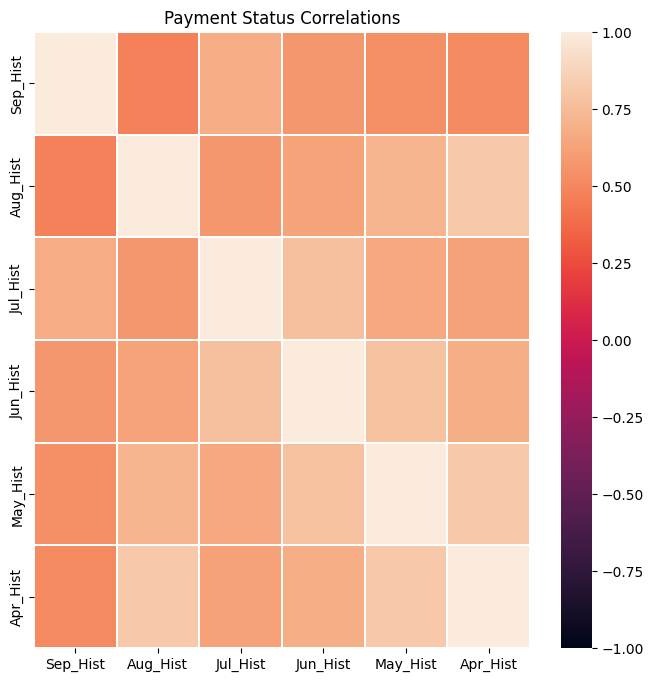

In [ ]:
# Payment Status
# Correlation Plot
values = list(column_names['history_names'].values())

plt.figure(figsize=(8,8))
plt.title('Payment Status Correlations')
corr = df[values].corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, linewidths=0.1, vmin=-1, vmax=1)
plt.show();

Correlation gets stronger the closer the months are in time.

### Minimal Viable Product

Let's test several models to get a base model to proceed with further testing

## Features and target variables

In [ ]:
X = df.loc[:,'limit_bal':'Apr_Pmt']
y = df['Default']

## Encode Categorical Variables

In [ ]:
categoricals = list(X.select_dtypes('object').columns)
numericals = list(X.select_dtypes('int64').columns)

# def encode_cats(categoricals, numericals):
#     """
#     Takes in a list of categorical columns and a list of numerical columns and returns the dataframe with encoded variables
#     """
#     ohe = OneHotEncoder(sparse=False, drop='first')
#     cat_matrix = ohe.fit_transform(X.loc[:, categoricals])
#     X_ohe = pd.DataFrame(cat_matrix,
#                          columns=ohe.get_feature_names(categoricals), #create meaningful column names
#                          index=X.index) #keep the same index values
    
#     return pd.concat([X.loc[:, numericals], X_ohe], axis=1)

In [ ]:
X = pd.get_dummies(data = X, columns = categoricals)

## Split the Data

In [ ]:
def train_test_val_split(X, y):
    """
    Input: X --> array of features, y --> target array
           set aside for testing.
    Output: Features and target split into train, val and test sets. 
            Test size = 20%
            Val size = 25%
            Converted to numpy arrays.
    """
    X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Split train/validate sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)

    # Convert to numpy arrays to help with generate indeces below
    X, y = np.array(X), np.array(y)

    return X_train, X_val, X_test, y_train, y_val, y_test

In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test = train_test_val_split(X, y)

In [ ]:
def scale_data(X_train, X_val, X_test):
    """
    Input: Features (numpy arrays)
    Output: Scaled data
    """
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_val_scaled, X_test_scaled

In [ ]:
X_train_scaled, X_val_scaled, X_test_scaled = scale_data(X_train, X_val, X_test)

## Train initial models

In [ ]:
def model_score(model_name, model, X_train_scaled, X_val_scaled,
                X_test_scaled, y_train, y_val, y_test, test=False):
    """
    Input: Transformed feature and target sets
    Output: Validation scores. If test=True, includes test scores
    """
    print('Calculating validation score...')

    my_model = model
    my_model.fit(X_train_scaled,y_train)
    print(f'{model_name} accuracy score: {my_model.score(X_val_scaled,y_val):.4}\n')

    if test:
        print("Calculating test score...")
        print(f'{model_name} accuracy score: {my_model.score(X_test_scaled,y_test):.4}\n')

    return my_model

In [ ]:
# knn = model_score('KNN', KNeighborsClassifier(n_neighbors=5),
#                        X_train_scaled,X_val_scaled, X_test_scaled,
#                        y_train, y_val, y_test,test=False)

# lr = model_score('LogReg', LogisticRegression(penalty=None),
#                        X_train_scaled,X_val_scaled, X_test_scaled,
#                        y_train, y_val, y_test,test=False)

rf = model_score('RF', RandomForestClassifier(),
                       X_train_scaled,X_val_scaled, X_test_scaled,
                       y_train, y_val, y_test,test=False)
        
# gbm = model_score('XGBoost', xgb.XGBClassifier(),
#                        X_train_scaled,X_val_scaled, X_test_scaled,
#                        y_train, y_val, y_test,test=False)

# svc = model_score('SVM', SVC(probability=True),
#                        X_train_scaled,X_val_scaled, X_test_scaled,
#                        y_train, y_val, y_test,test=False)

Calculating validation score...
RF accuracy score: 0.8175



Support Vector Machine performs the best with an accuracy of 0.8193. However, we will move forward with Random Forest because it is less computationally expensive.<br>
Edit: removed execution for other models to save time.

## Performance Metrics

### Confusion Matrix

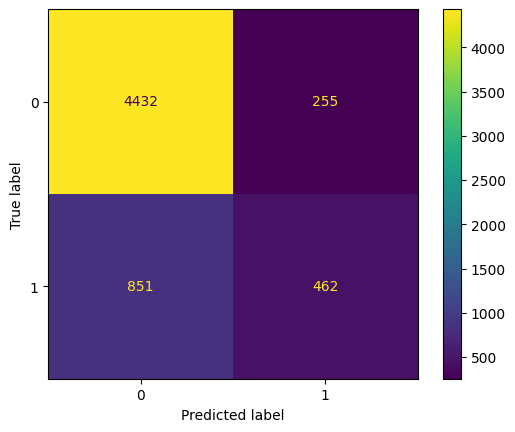

In [ ]:
cm = confusion_matrix(y_test, rf.predict(X_test_scaled), labels=rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf.classes_)
disp.plot()
plt.show()

### Classification Report

In [ ]:
y_preds_rf = rf.predict(X_test_scaled)
print(classification_report(y_test, y_preds_rf))

              precision    recall  f1-score   support

           0       0.84      0.95      0.89      4687
           1       0.64      0.35      0.46      1313

    accuracy                           0.82      6000
   macro avg       0.74      0.65      0.67      6000
weighted avg       0.80      0.82      0.79      6000



## Optimization

What are we optimizing for? In this case, we are optimizing recall. Recall is a performance metric which attempts to answer the question: What proportion of actual positives was identified correctly? Mathematically, the formula is

$RecallScore = \frac{TP}{TP + FN}$

TP = True Positive, or a correctly predicted default

FN = False Negative, or an incorrectly predicted non-default

Ideally, we do not want to miss any potentially defaults to fall through the cracks, so our optimal model will minimize False Negatives (optimize Recall Score)

## Feature Selection
There are many feature selection scores one could perform to determine
which features are most useful. For this case, we will use Feature Importance.

Feature Importance is the process of assigning scores to each feature, depending on how useful it is in predicting the target variable

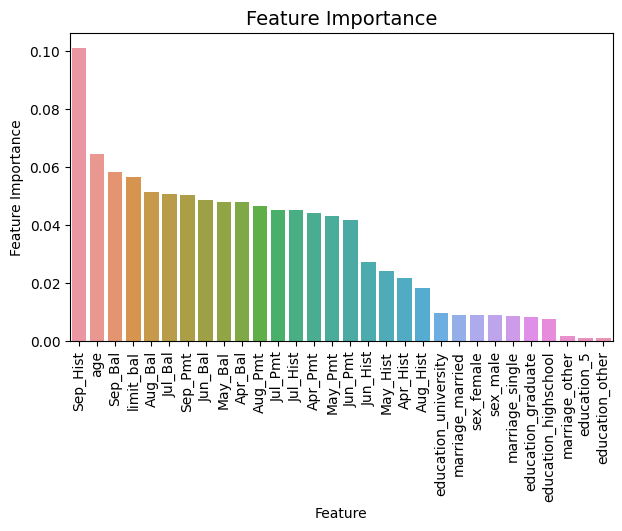

In [ ]:
temp = pd.DataFrame({'Feature': list(X.columns), 'Feature Importance': rf.feature_importances_})
temp = temp.sort_values(by="Feature Importance", ascending=False)

plt.figure(figsize=(7,4))
plt.title('Feature Importance', fontsize=14)
s=sns.barplot(x='Feature', y='Feature Importance', data=temp)
s.set_xticklabels(s.get_xticklabels(), rotation=90)
plt.show();

The top features are shown in the chart. It's interesting how 'age' is the second most important feature. Let's keep all of them except the last 6, the categorical variables.

In [ ]:
# Update dataframe
X = X.iloc[:, np.argsort(rf.feature_importances_,)[7:]]

## Hyperparamter Tuning
Let's search for optimal parameters for our model

In [ ]:
# # Define parameter values that should be searched
# bootstrap = [True, False]
# min_samples_leaf = [1,2,4]
# min_samples_split = [2,5,10]
# n_estimators = [50,100,150,200]
# max_depth = [4,6,10,12, None]

In [ ]:
# # Specify "parameter distributions" rather than a "parameter grid"

# param_dist = dict(n_estimators=n_estimators, max_depth = max_depth, bootstrap=bootstrap,
#                   min_samples_leaf=min_samples_leaf,min_samples_split=min_samples_split)
# print(param_dist)

In [ ]:
# # n_iter controls the number of searches

# rand = RandomizedSearchCV(RandomForestClassifier(), param_dist, cv=10, scoring='accuracy',
#                           n_iter=10, random_state=42)
# rand.fit(X_train_scaled, y_train)

# # Uncomment line below to print
# rand.cv_results_

In [ ]:
# def get_best_model(model_grid):
#     best_k = model_grid.cv_results_['rank_test_score'][0]
#     print (f"Mean score: {model_grid.cv_results_['mean_test_score'][best_k]}",
#            f"Std: {model_grid.cv_results_['std_test_score'][best_k]}")

In [ ]:
# # Examine the best model
# print(rand.best_score_)
# print(rand.best_params_)
# get_best_model(rand)

In [ ]:
# best_params_ = rand.best_params_
best_params_ = {'n_estimators': 50, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 10, 'bootstrap': False}

We found optimal parameters, not a huge improvement, but anything helps<br>
Edit: Skipped hyperparameter tuning to save time. Directly used best parameters.

## Class Imbalance

### Under/Oversampling

In [ ]:
def over_under_sample(X_train, y_train, Under=True, Over=True):
    """
    Input: training features and target
    Output: under/oversampled datasets
    """
    rus = RandomUnderSampler(random_state=42)
    ros = RandomOverSampler(random_state=42)

    if Under and Over:
        X_train_under, y_train_under = rus.fit_resample(X_train, y_train)
        X_train_over, y_train_over = ros.fit_resample(X_train, y_train)
        return X_train_under, y_train_under, X_train_over, y_train_over
    elif Under:
        X_train_under, y_train_under = rus.fit_resample(X_train, y_train)
        return X_train_under, y_train_under
    else:
        X_train_over, y_train_over = ros.fit_resample(X_train, y_train)
        return X_train_over, y_train_over

In [ ]:
# Split data
X_train, X_val, X_test, y_train, y_val, y_test = train_test_val_split(X, y)

# Random under/over sampling
X_train_under, y_train_under, X_train_over, y_train_over = over_under_sample(X_train, y_train, Under=True, Over=True)


### Undersampling

In [ ]:
# Scale
X_train_scaled_under, X_val_scaled, X_test_scaled = scale_data(X_train_under, X_val, X_test)

# Score
rf_under = model_score('RF', RandomForestClassifier(**best_params_),
                 X_train_scaled_under, X_val_scaled, X_test_scaled,
                 y_train_under, y_val, y_test, test=False)

Calculating validation score...
RF accuracy score: 0.7497



In [ ]:
y_preds = rf_under.predict(X_test_scaled)
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.88      0.77      0.83      4687
           1       0.44      0.64      0.52      1313

    accuracy                           0.74      6000
   macro avg       0.66      0.71      0.67      6000
weighted avg       0.79      0.74      0.76      6000



### Oversampling

In [ ]:
# Scale
X_train_scaled_over, X_val_scaled, X_test_scaled = scale_data(X_train_over, X_val, X_test)

# Score
rf_over = model_score('RF', RandomForestClassifier(**best_params_),
                 X_train_scaled_over, X_val_scaled, X_test_scaled,
                 y_train_over, y_val, y_test, test=False)

Calculating validation score...
RF accuracy score: 0.7865



In [ ]:
# Classification report
y_preds = rf_over.predict(X_test_scaled)
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.87      0.84      0.86      4687
           1       0.50      0.56      0.53      1313

    accuracy                           0.78      6000
   macro avg       0.69      0.70      0.69      6000
weighted avg       0.79      0.78      0.78      6000



Overall accuracy decreased by about 0.04, and recall decreased by about 0.10. However, precision increased by 0.18. That may be good or bad, depending on what costs more. Is it more costly to incorrectly predict true defaults, or is it more costly to incorrectly identifythose who will not default? That is up to management to decide.

## Analyze Results

### Final Model

In [ ]:
print("Random Forest with the following parameters:\n")
print(best_params_)

Random Forest with the following parameters:

{'n_estimators': 50, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 10, 'bootstrap': False}


Sometimes the best model is the simplest. The model with minimal manipulation yielded the highest recall score of 0.95. After feature selection and hyperparameter tuning, recall decreased to 0.79.

Let's check for overfitting. Overfitting means the model is strong at predicting the data it was trained, but weak at generalizing to unseen data. Lets test the model on never-before-seen data points and see how it performs

### Check for Overfitting

In [ ]:
# features and target
X = df.loc[:,'limit_bal':'Apr_Pmt']
y = df['Default']

# encode categorical

X = pd.get_dummies(data = X, columns = categoricals)

# Split data
X_train, X_val, X_test, y_train, y_val, y_test = train_test_val_split(X, y)

# Scale
X_train_scaled, X_val_scaled, X_test_scaled = scale_data(X_train, X_val, X_test)

# Model score
rf = model_score('RF', RandomForestClassifier(**best_params_),
                 X_train_scaled, X_val_scaled, X_test_scaled,
                 y_train, y_val, y_test, test=True)

Calculating validation score...
RF accuracy score: 0.8198

Calculating test score...
RF accuracy score: 0.821



Validation score and test score are similar so there is no sign overfitting

### F-Beta Score

In [ ]:
print(f"f-beta score: {fbeta_score(y_test, rf.predict(X_test_scaled), average='weighted', beta=5.0):.4}")

f-beta score: 0.8187


### ROC Curve

ROC AUC score =  0.7745333099557021


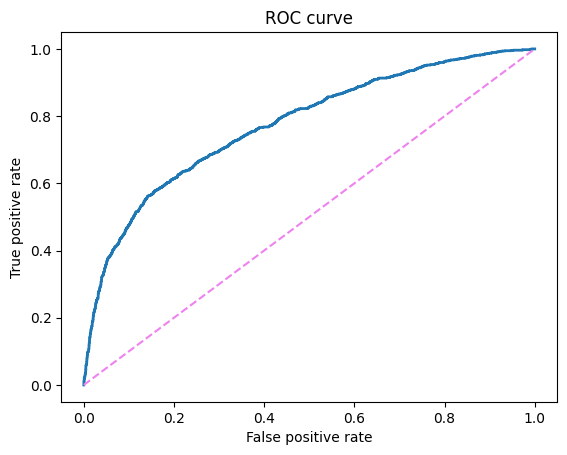

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, rf.predict_proba(X_test_scaled)[:,1])

plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');
print("ROC AUC score = ", roc_auc_score(y_test, rf.predict_proba(X_test_scaled)[:,1]))

# Replicate model with from solution, get labels and predictions

In [ ]:
clf = RandomForestClassifier(**best_params_)
clf.fit(X_train, y_train)
score = clf.predict(X_test)

# Evaluate Fairness with Aequitas

## Get sensitive features, prepare for Aequitas

In [ ]:
sex = ['Male' if x == 1 else 'Female' for x in X_test['sex_male']]
amount_median = X_test['limit_bal'].median()
amount = ['Low' if x < amount_median else 'High' for x in X_test['limit_bal']]

In [ ]:
pred_data = pd.DataFrame(list(zip(sex, amount, score, y_test)), columns=['sex', 'amount', 'score', 'label_value'])
pred_data['sex_amount'] = pred_data['sex'] + '_' + pred_data['amount']
pred_data

sex amount  score  label_value   sex_amount
0       Male    Low      0            0     Male_Low
1     Female   High      0            0  Female_High
2     Female    Low      0            0   Female_Low
3       Male    Low      0            0     Male_Low
4     Female    Low      0            1   Female_Low
...      ...    ...    ...          ...          ...
5995  Female   High      0            0  Female_High
5996  Female   High      1            1  Female_High
5997  Female    Low      0            0   Female_Low
5998  Female    Low      0            0   Female_Low
5999  Female   High      0            0  Female_High

[6000 rows x 5 columns]

## Break down plots by sex and amount

Text(0.5, 1.0, 'Bar Plot of Actual Defaults by Sex')

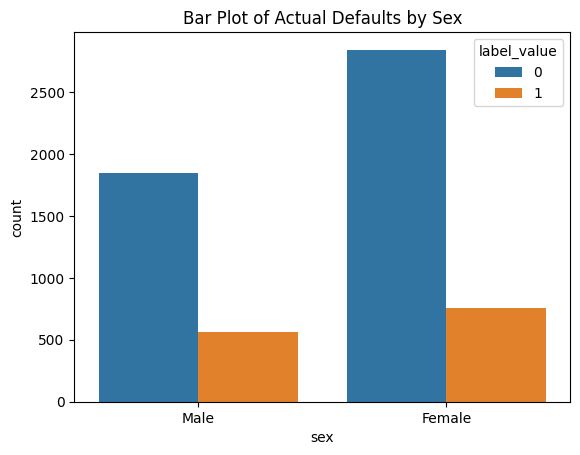

In [ ]:
label_by_sex = sns.countplot(x="sex", hue="label_value", data=pred_data)
plt.title("Bar Plot of Actual Defaults by Sex")

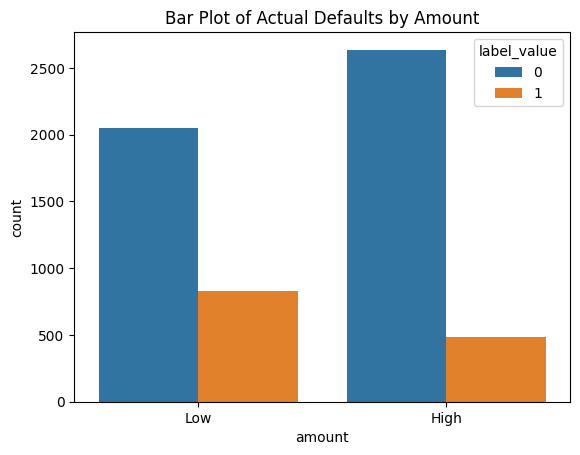

In [ ]:
label_by_amount = sns.countplot(x="amount", hue="label_value", data=pred_data)
plt.title("Bar Plot of Actual Defaults by Amount");

Text(0.5, 1.0, 'Bar Plot of Predicted Defaults by Sex')

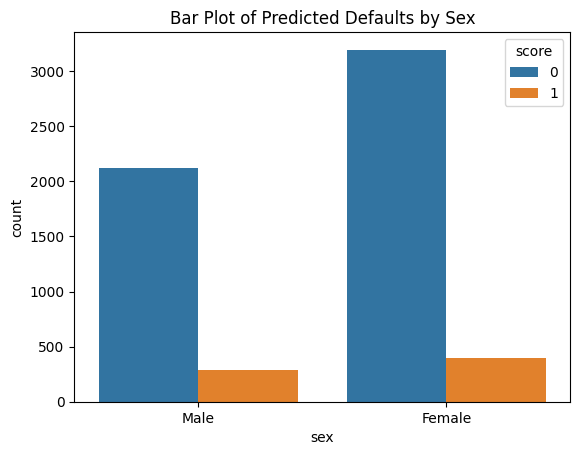

In [ ]:
score_by_sex = sns.countplot(x="sex", hue="score", data=pred_data)
plt.title("Bar Plot of Predicted Defaults by Sex")

Text(0.5, 1.0, 'Bar Plot of Predicted Defaults by Amount')

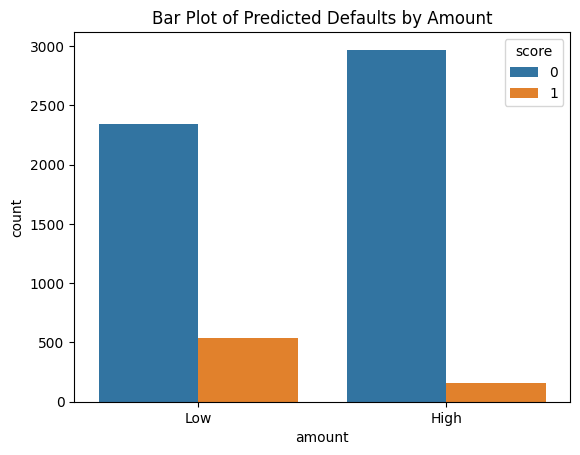

In [ ]:
score_by_amount = sns.countplot(x="amount", hue="score", data=pred_data)
plt.title("Bar Plot of Predicted Defaults by Amount")

Regardless of sensitive features, our model seems overly optimistic. It's predicting much less defaults than actual. 

## Plots for intersection of sex and amount

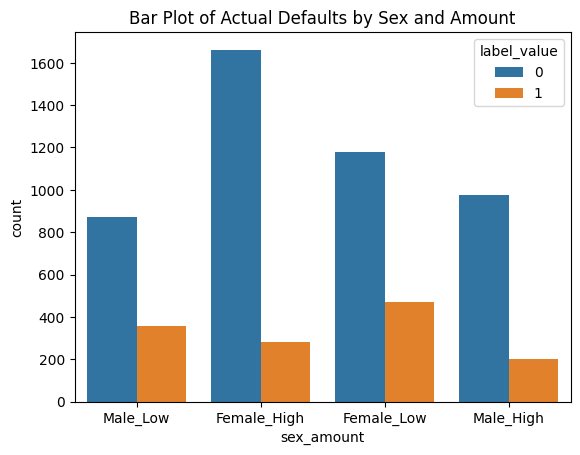

In [ ]:
label_by_sex_amount = sns.countplot(x="sex_amount", hue="label_value", data=pred_data)
plt.title("Bar Plot of Actual Defaults by Sex and Amount");

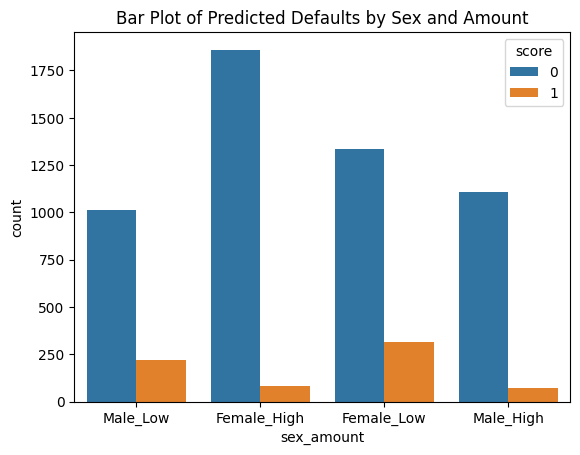

In [ ]:
score_by_sex_amount = sns.countplot(x="sex_amount", hue="score", data=pred_data)
plt.title("Bar Plot of Predicted Defaults by Sex and Amount");

Again, our model is predicting less defaults than actual. 

## Plotting metrics by groups and intersections of groups

In [ ]:
g = Group()
xtab, _ = g.get_crosstabs(pred_data)

In [ ]:
#@markdown Get a sense of the predicted positives/negatives and confusion matrix
absolute_metrics = g.list_absolute_metrics(xtab)
xtab[[col for col in xtab.columns if col not in absolute_metrics]]

model_id score_threshold    k attribute_name attribute_value   pp    pn  \
0         0      binary 0/1  688            sex          Female  400  3194   
1         0      binary 0/1  688            sex            Male  288  2118   
2         0      binary 0/1  688         amount            High  154  2968   
3         0      binary 0/1  688         amount             Low  534  2344   
4         0      binary 0/1  688     sex_amount     Female_High   84  1860   
5         0      binary 0/1  688     sex_amount      Female_Low  316  1334   
6         0      binary 0/1  688     sex_amount       Male_High   70  1108   
7         0      binary 0/1  688     sex_amount        Male_Low  218  1010   

    fp   fn    tn   tp  group_label_pos  group_label_neg  group_size  \
0  134  487  2707  266              753             2841        3594   
1   91  363  1755  197              560             1846        2406   
2   37  368  2600  117              485             2637        3122   
3  188  482  1862  346              828             2050        2878   
4   26  224  1636   58              282             1662        1944   
5  108  263  1071  208              471             1179        1650   
6   11  144   964   59              203              975        1178   
7   80  219   791  138              357              871        1228   

   total_entities  
0            6000  
1            6000  
2            6000  
3            6000  
4            6000  
5            6000  
6            6000  
7            6000

Aequitas uses some names and acronyms unlike what we have used in class:
- `precision` is PPV
- `ppr` $ = \frac{\text{PP}_G}{P}$ where $P$ is the total number of people predicted positive across all groups, and $\text{PP}_G$ is the number of people in group $G$ predicted positive.
- `pprev` is the Selection Rate
- `prev` is the Prevalence

In [ ]:
#@markdown View calculated "absolute metrics" (like false positive rates) for each group
xtab[['attribute_name', 'attribute_value'] + ['tpr', 'tnr', 'for', 'fdr', 'fpr', 'fnr', 'precision', 'pprev', 'prev']].round(2)

attribute_name attribute_value   tpr   tnr   for   fdr   fpr   fnr  \
0            sex          Female  0.35  0.95  0.15  0.34  0.05  0.65   
1            sex            Male  0.35  0.95  0.17  0.32  0.05  0.65   
2         amount            High  0.24  0.99  0.12  0.24  0.01  0.76   
3         amount             Low  0.42  0.91  0.21  0.35  0.09  0.58   
4     sex_amount     Female_High  0.21  0.98  0.12  0.31  0.02  0.79   
5     sex_amount      Female_Low  0.44  0.91  0.20  0.34  0.09  0.56   
6     sex_amount       Male_High  0.29  0.99  0.13  0.16  0.01  0.71   
7     sex_amount        Male_Low  0.39  0.91  0.22  0.37  0.09  0.61   

   precision  pprev  prev  
0       0.66   0.11  0.21  
1       0.68   0.12  0.23  
2       0.76   0.05  0.16  
3       0.65   0.19  0.29  
4       0.69   0.04  0.15  
5       0.66   0.19  0.29  
6       0.84   0.06  0.17  
7       0.63   0.18  0.29

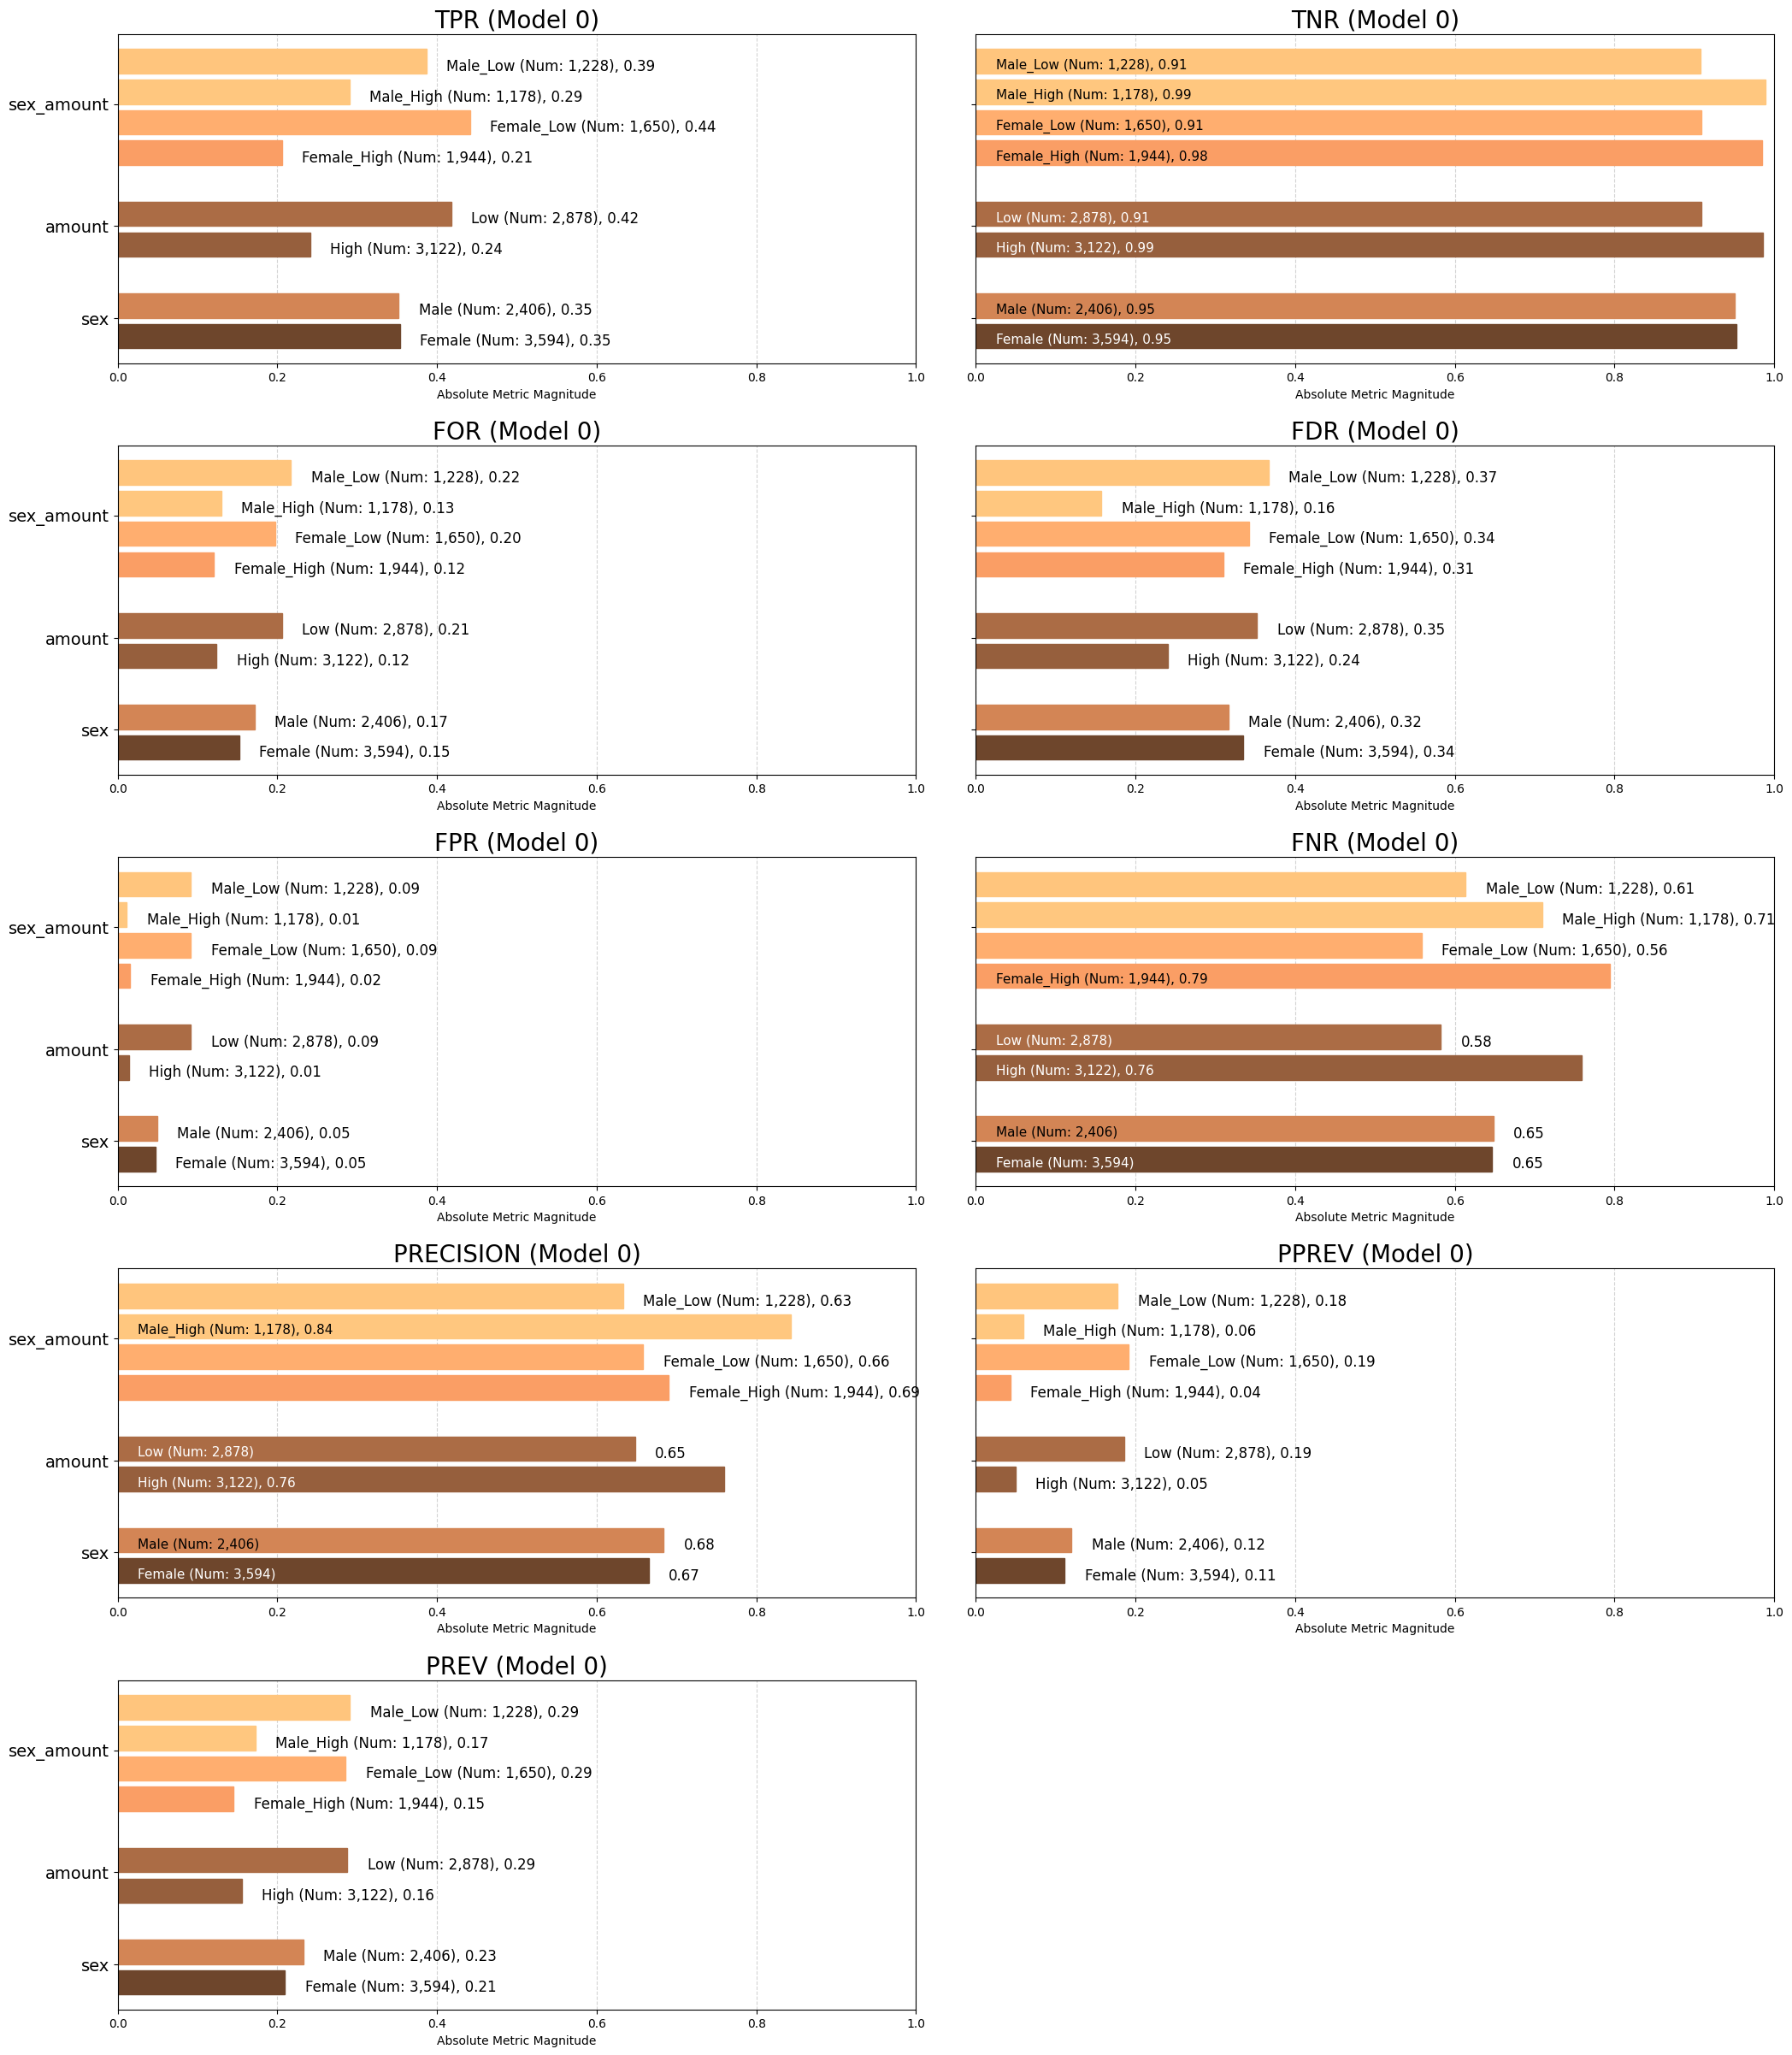

<Figure size 640x480 with 0 Axes>

In [ ]:
#@markdown
aqp = Plot()
p = aqp.plot_group_metric_all(xtab, metrics=['tpr', 'tnr', 'for', 'fdr', 'fpr', 'fnr', 'precision', 'pprev', 'prev'], ncols=2)

For banks and financial institutions, we want to catch as many defaults as possible. It's important to minimize false omission rate (FOR) and false negative rate (FNR). A false omission is more severe than a false discovery. <br>
For credit card clients, we want to avoid being labeled as will default when we actually won't default. It's important to minimize false discovery rate (FDR) and false positive rate (FPR). <br>
In general, for the ADS to be fair, we need to make sure that predicted prevalence (fraction of predicted positive within group) is consistent with prevalence (base rate). 

## Evaluate disparities for metrics between groups and intersections of groups

In [ ]:
#@title
b = Bias()
bdf = b.get_disparity_predefined_groups(xtab, original_df=pred_data, ref_groups_dict={'sex':'Male', 'amount':'High', 'sex_amount': 'Male_High'}, alpha=0.05, mask_significance=True)

get_disparity_predefined_group()


In [ ]:
#@title For banks and financial institutions
calculated_disparities = b.list_disparities(bdf)
bdf[['attribute_name', 'attribute_value'] + ['for_disparity', 'fnr_disparity']]

# Look for disparity values outside of the bounds 0.8 <= disparity <= 1.2

attribute_name attribute_value  for_disparity  fnr_disparity
0            sex          Female       0.889638       0.997735
1            sex            Male       1.000000       1.000000
2         amount            High       1.000000       1.000000
3         amount             Low       1.658462       0.767204
4     sex_amount     Female_High       0.926643       1.119779
5     sex_amount      Female_Low       1.516971       0.787170
6     sex_amount       Male_High       1.000000       1.000000
7     sex_amount        Male_Low       1.668399       0.864788

Notice The FPR disparity for sex="Female" is 0.894348. That means that Female group in the dataset have an FPR 0.894348x that of Male group.

We can also look at mosaic plots of the disparity. In these plots, the size of each block corresponds to the relative size of the population.

In [ ]:
#@title For credit card clients
calculated_disparities = b.list_disparities(bdf)
bdf[['attribute_name', 'attribute_value'] + ['fdr_disparity', 'fpr_disparity']]

# Look for disparity values outside of the bounds 0.8 <= disparity <= 1.2

attribute_name attribute_value  fdr_disparity  fpr_disparity
0            sex          Female       1.060220       0.956806
1            sex            Male       1.000000       1.000000
2         amount            High       1.000000       1.000000
3         amount             Low       1.465330       6.536005
4     sex_amount     Female_High       1.969697       1.386610
5     sex_amount      Female_Low       2.174914       8.119362
6     sex_amount       Male_High       1.000000       1.000000
7     sex_amount        Male_Low       2.335279       8.141113

Notice The FPR disparity for sex="Female" is 1.078225. That means that Female group in the dataset have an FPR 1.078225x that of Male group.

We can also look at mosaic plots of the disparity. In these plots, the size of each block corresponds to the relative size of the population.

In [ ]:
#@title General fairness
calculated_disparities = b.list_disparities(bdf)
# Calculate ratio between predicted and true prevalence
bdf['pprev/prev'] = bdf['pprev'] / bdf['prev']
bdf[['attribute_name', 'attribute_value'] + ['pprev', 'prev', 'pprev/prev']]

# Look for disparity values outside of the bounds 0.8 <= disparity <= 1.2

attribute_name attribute_value     pprev      prev  pprev/prev
0            sex          Female  0.111297  0.209516    0.531208
1            sex            Male  0.119701  0.232751    0.514286
2         amount            High  0.049327  0.155349    0.317526
3         amount             Low  0.185546  0.287700    0.644928
4     sex_amount     Female_High  0.043210  0.145062    0.297872
5     sex_amount      Female_Low  0.191515  0.285455    0.670913
6     sex_amount       Male_High  0.059423  0.172326    0.344828
7     sex_amount        Male_Low  0.177524  0.290717    0.610644

TODO: Analyze tables above.

get_disparity_major_group()


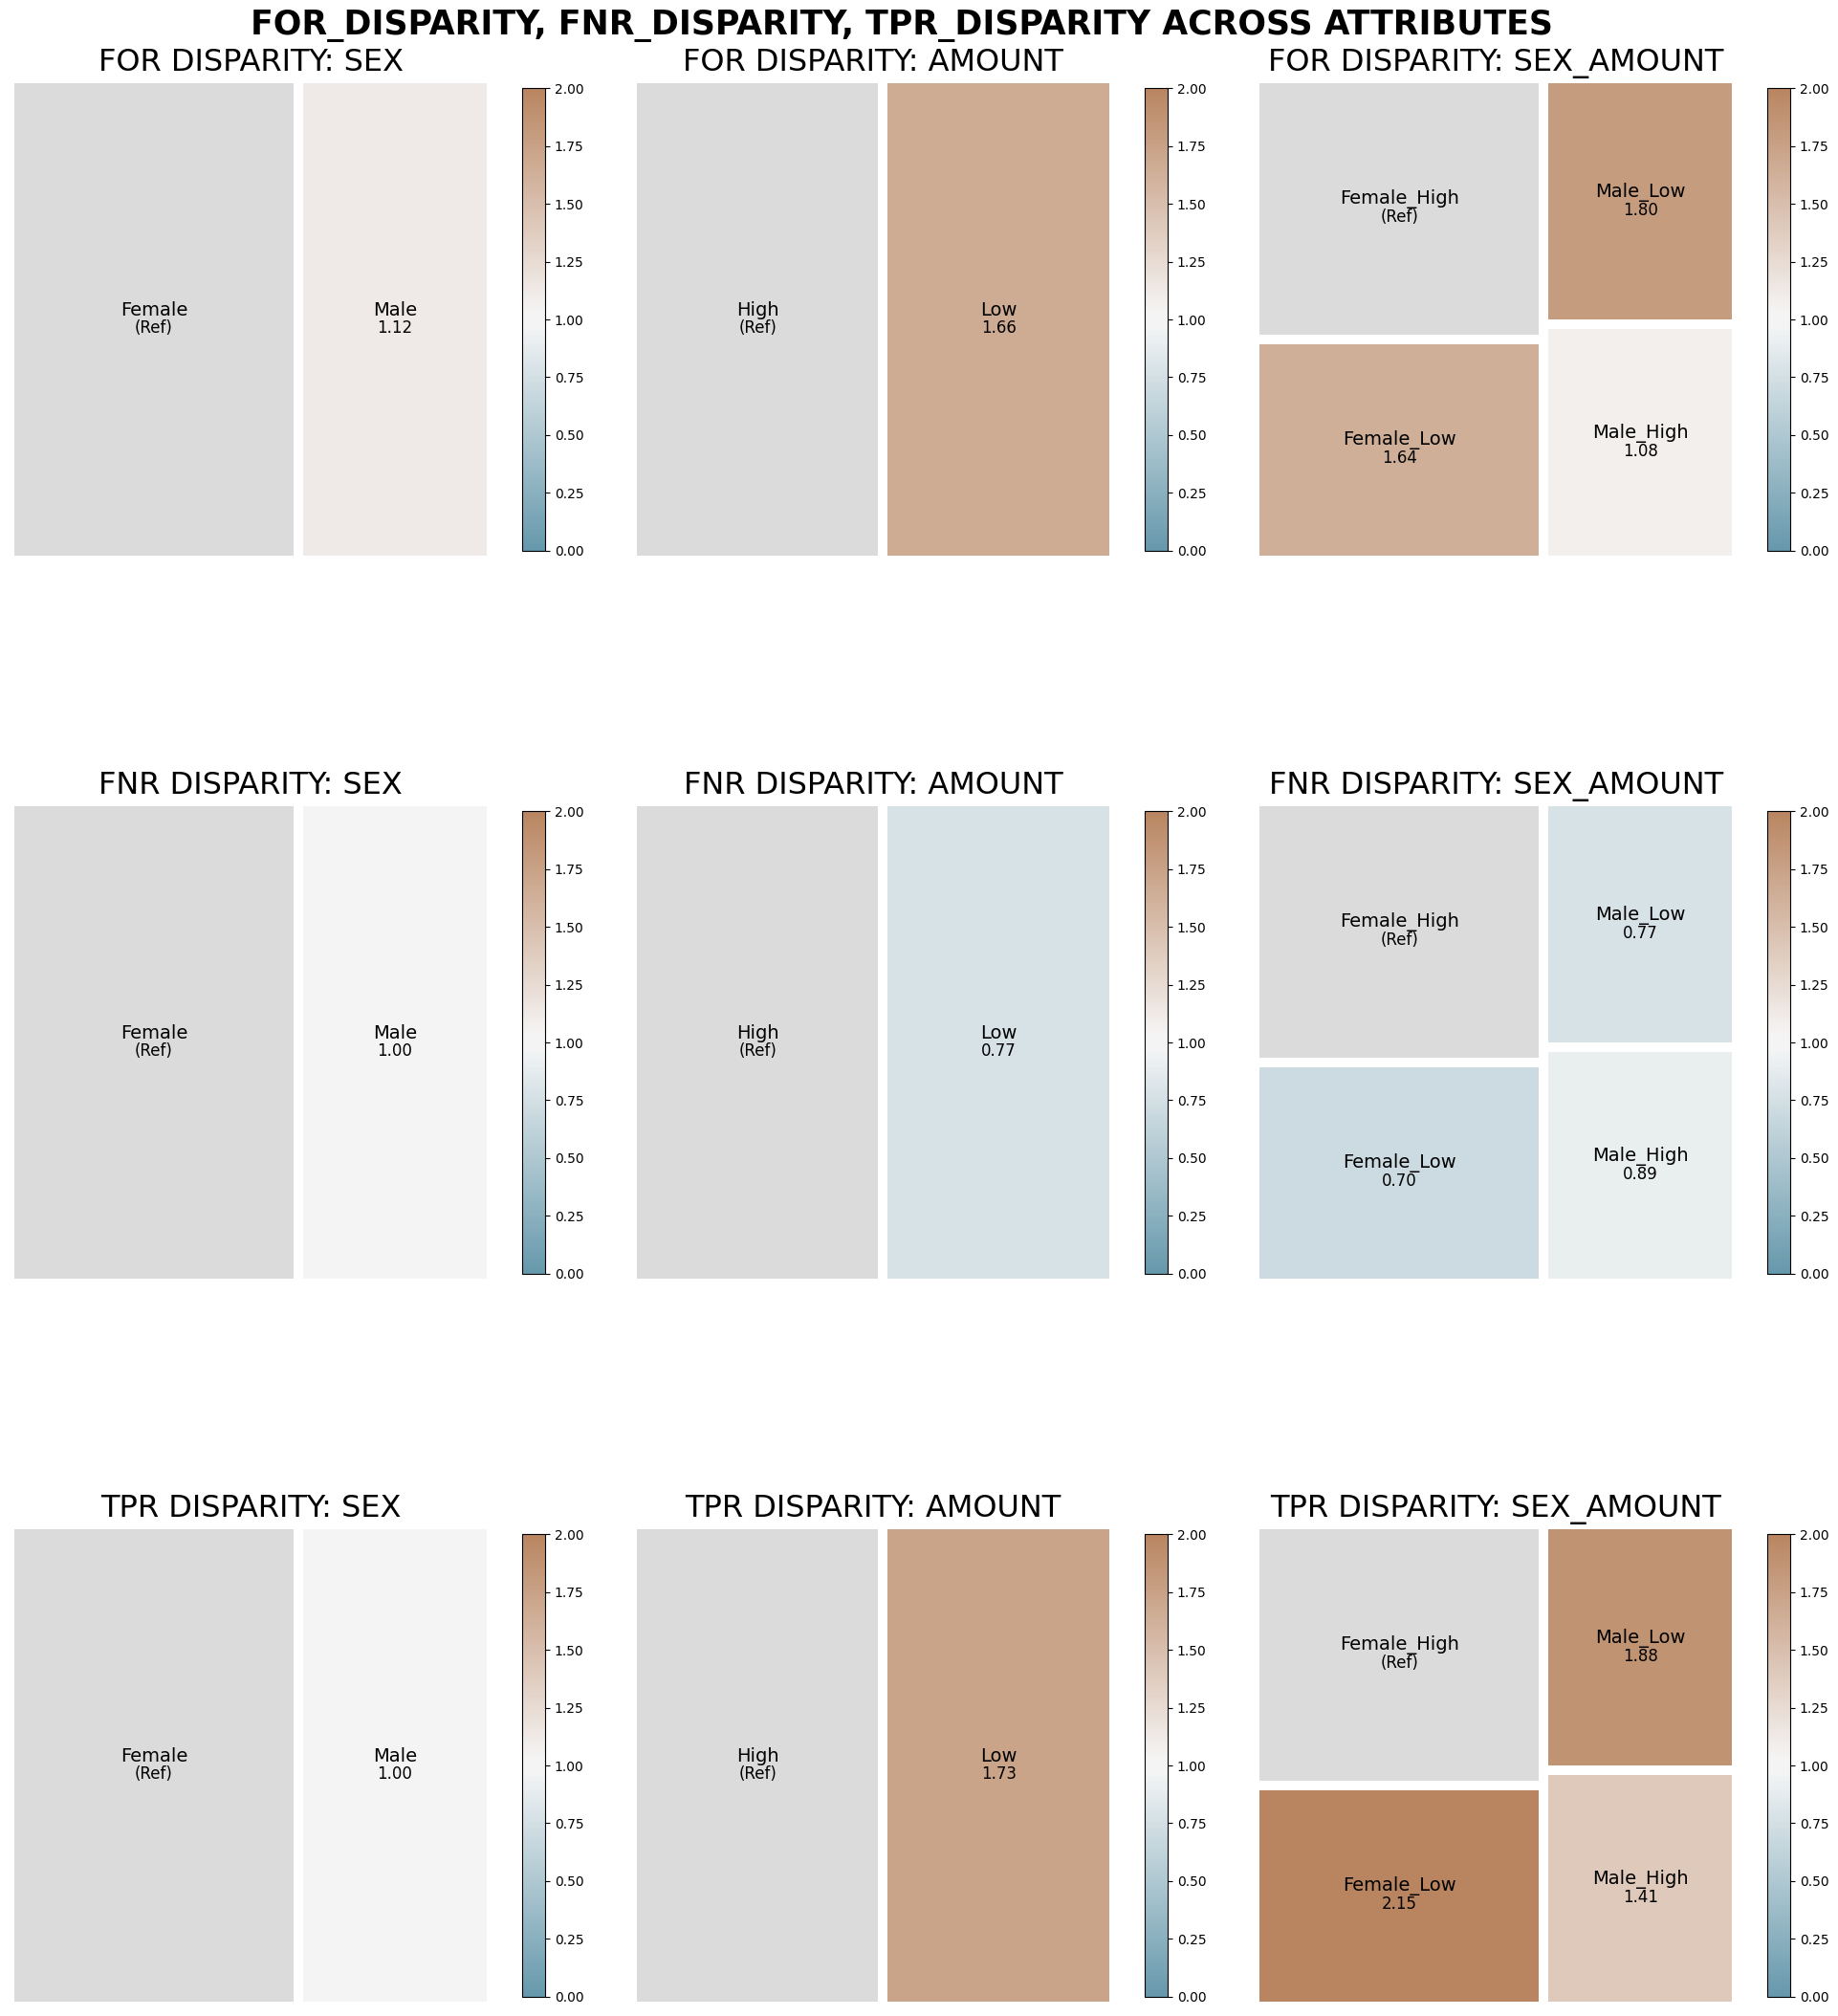

In [ ]:
#@title Metrics for banks
majority_bdf = b.get_disparity_major_group(xtab, original_df=pred_data, mask_significance=True)
j = aqp.plot_disparity_all(majority_bdf, metrics=['for_disparity','fnr_disparity','tpr_disparity'], significance_alpha=0.05)

Banks need to detect as many defaults as possible. 

get_disparity_major_group()


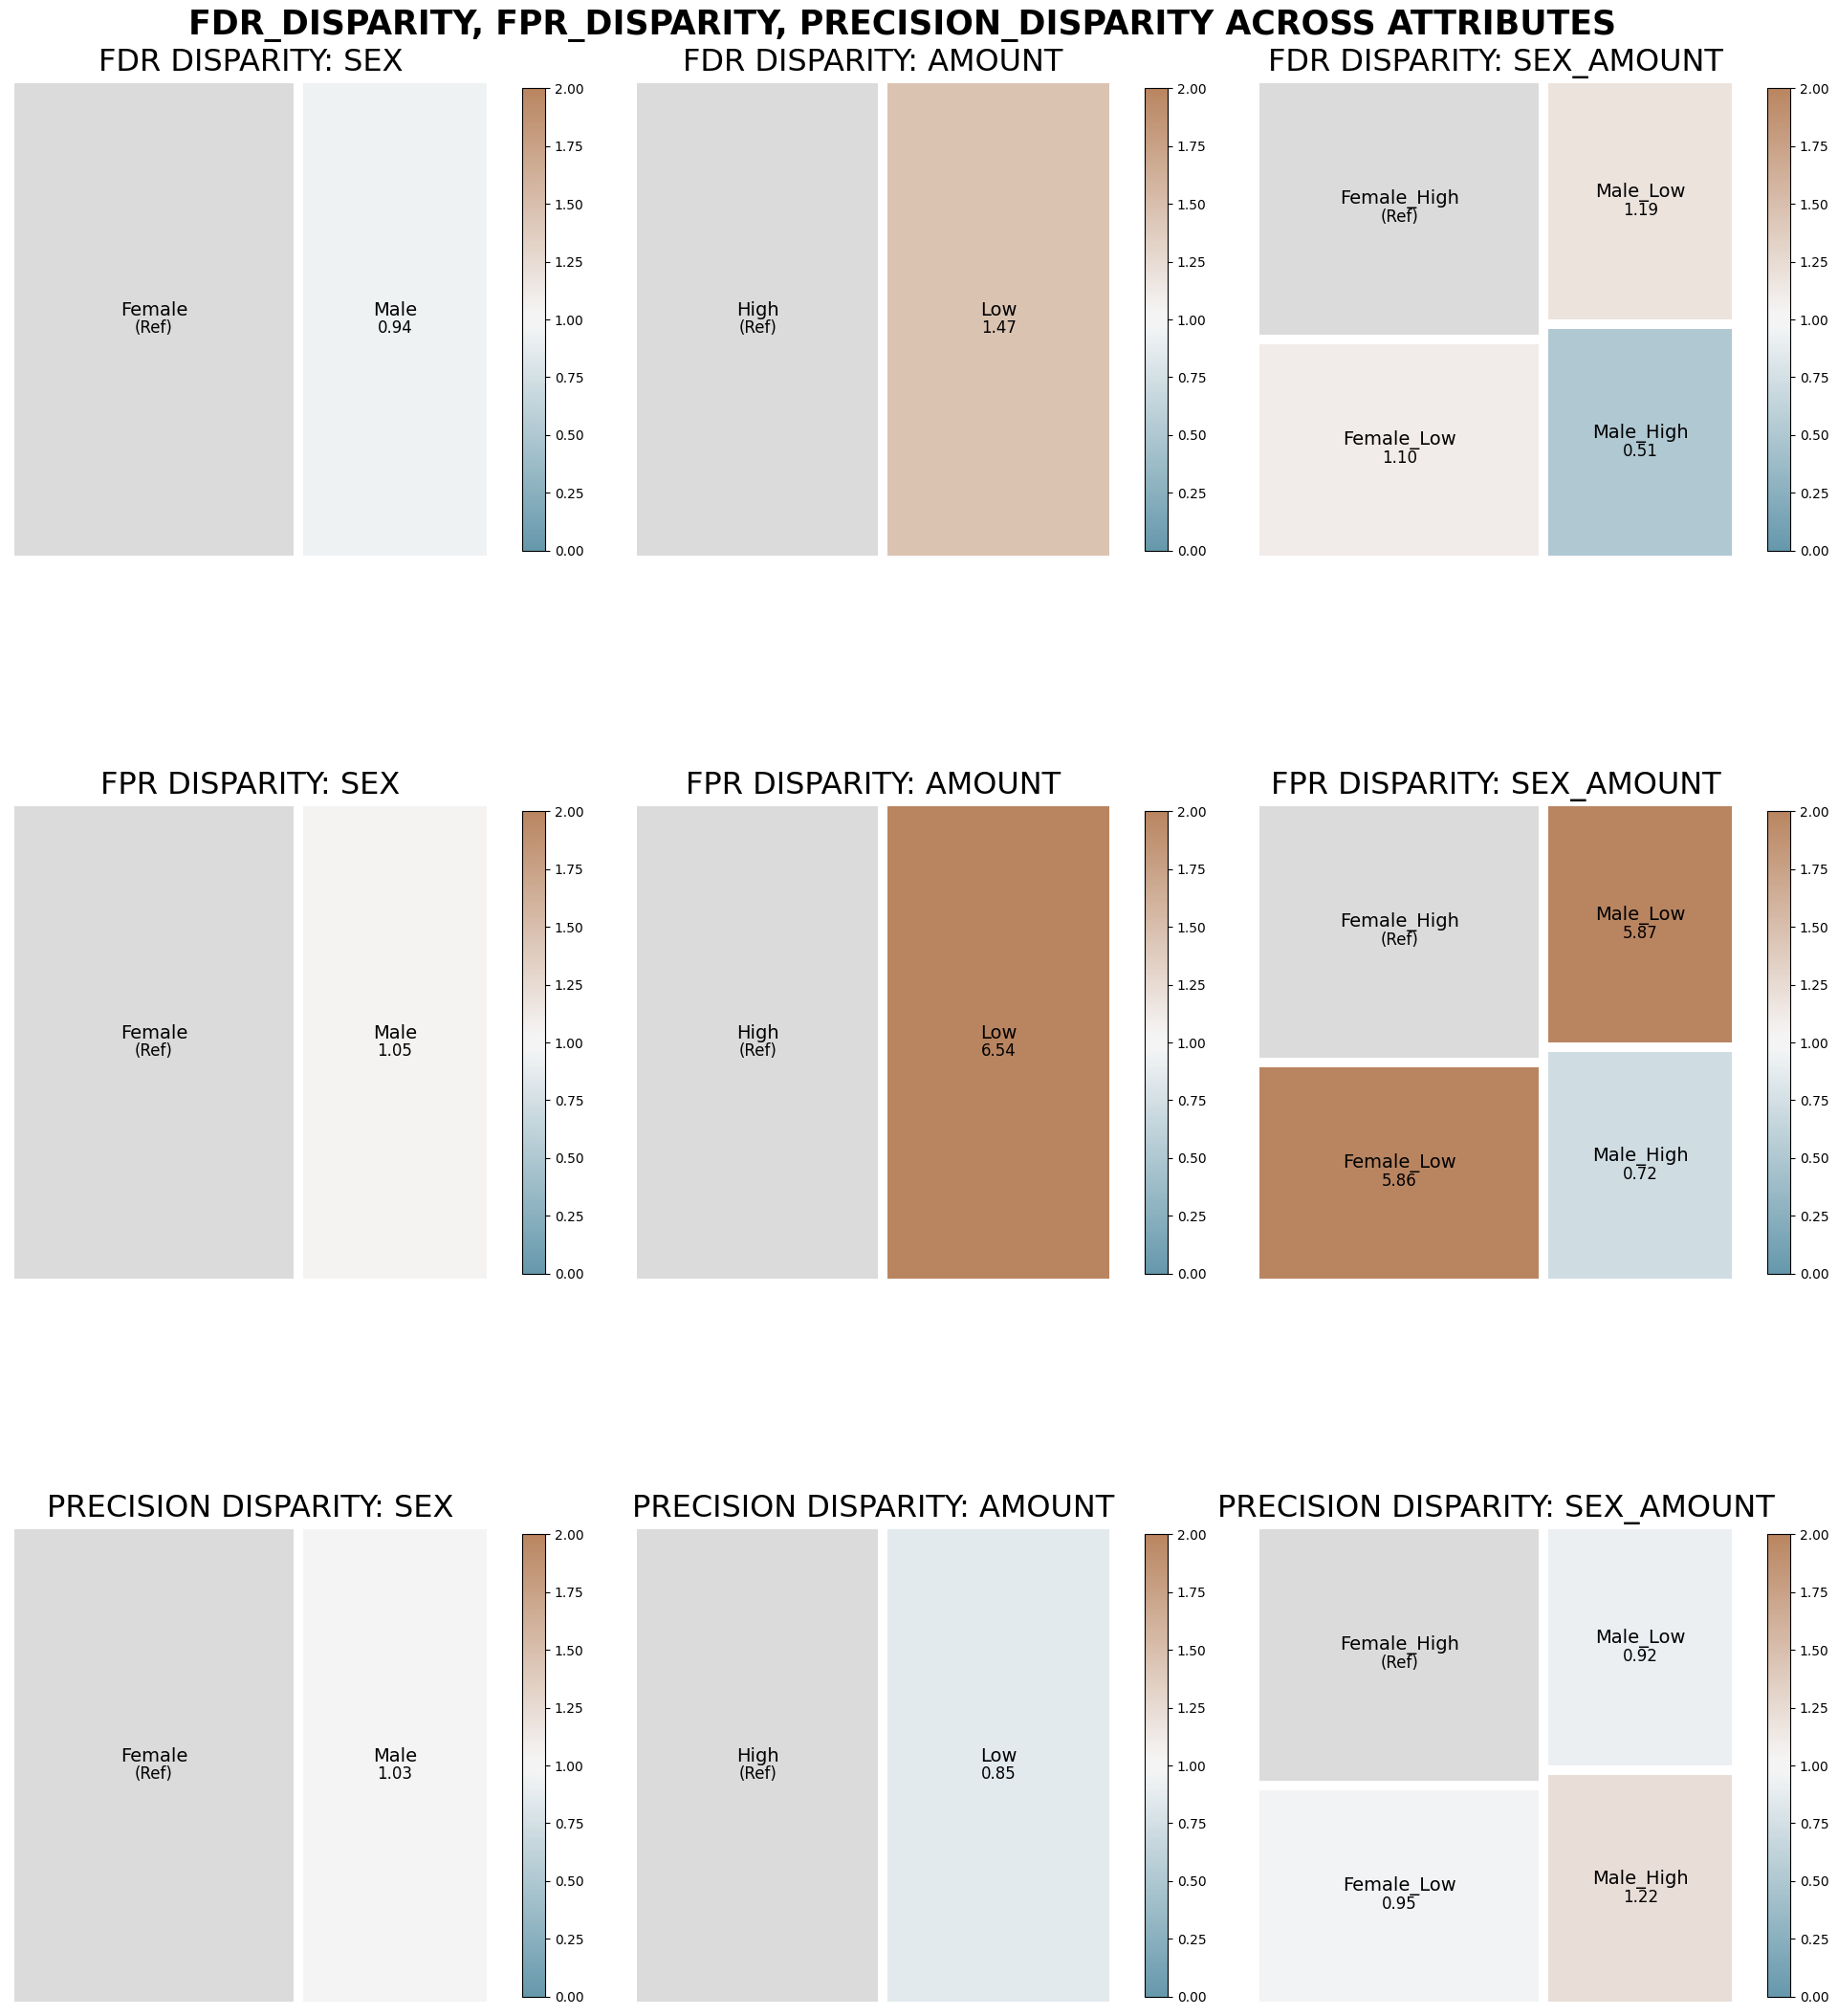

In [ ]:
#@title Metrics for clients
majority_bdf = b.get_disparity_major_group(xtab, original_df=pred_data, mask_significance=True)
j = aqp.plot_disparity_all(majority_bdf, metrics=['fdr_disparity','fpr_disparity','precision_disparity'], significance_alpha=0.05)

We can also apply statistical testing to see if disparities are significantly different from each other.

Those mosaics colored in green are those that have *Parity* between metrics at an $\alpha = 0.05$ significance level, and red indicates they have *disparity*.

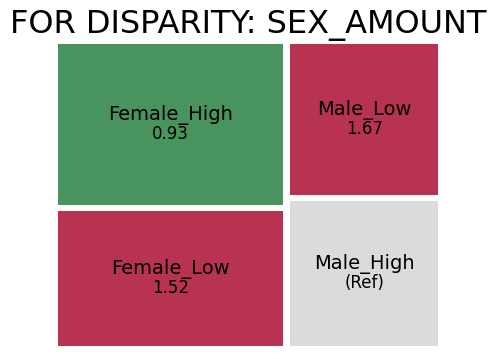

In [ ]:
#@title
f = Fairness()
fdf = f.get_group_value_fairness(bdf)
parity_detrminations = f.list_parities(fdf)
fdf[['attribute_name', 'attribute_value'] + absolute_metrics + calculated_disparities + parity_detrminations].style
m = aqp.plot_fairness_disparity(fdf, group_metric='for', attribute_name='sex_amount')

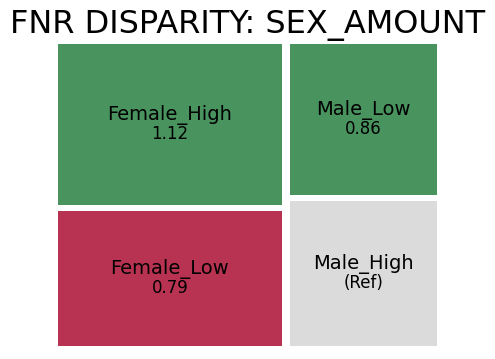

In [ ]:
m = aqp.plot_fairness_disparity(fdf, group_metric='fnr', attribute_name='sex_amount')

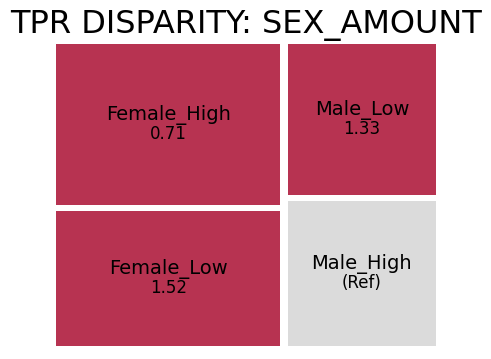

In [ ]:
m = aqp.plot_fairness_disparity(fdf, group_metric='tpr', attribute_name='sex_amount')

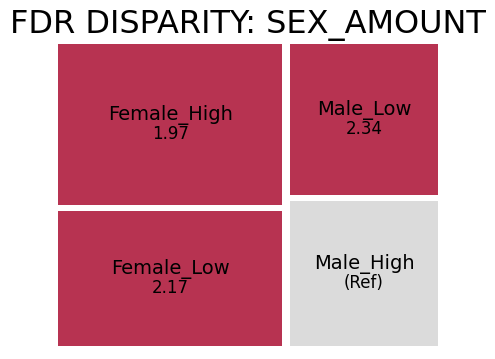

In [ ]:
m = aqp.plot_fairness_disparity(fdf, group_metric='fdr', attribute_name='sex_amount')

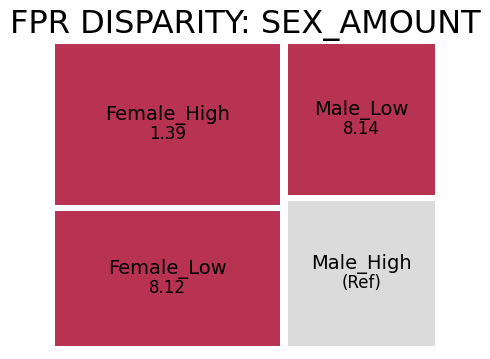

In [ ]:
m = aqp.plot_fairness_disparity(fdf, group_metric='fpr', attribute_name='sex_amount')

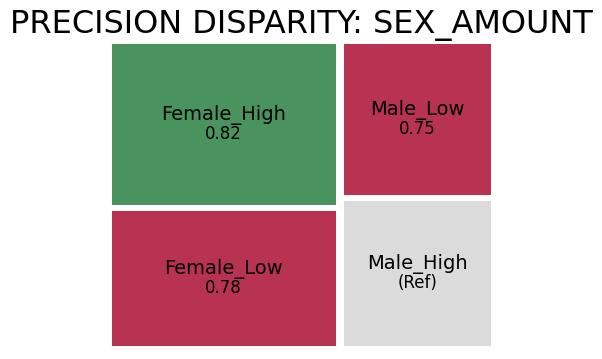

In [ ]:
m = aqp.plot_fairness_disparity(fdf, group_metric='precision', attribute_name='sex_amount')

# Evaluate Robustness and Feature Importance with SHAP

## Initialize SHAP

In [ ]:
# Initialize the explainer
explainer = shap.TreeExplainer(clf, X_train, feature_perturbation="interventional")
# Apply it to the test data
shap_values = explainer.shap_values(X_test)

 99%|===================| 11917/12000 [02:20<00:00]       

In [ ]:
y_pred = clf.predict(X_test)
y_score = clf.predict_proba(X_test)

## Summary plot - global interpretability

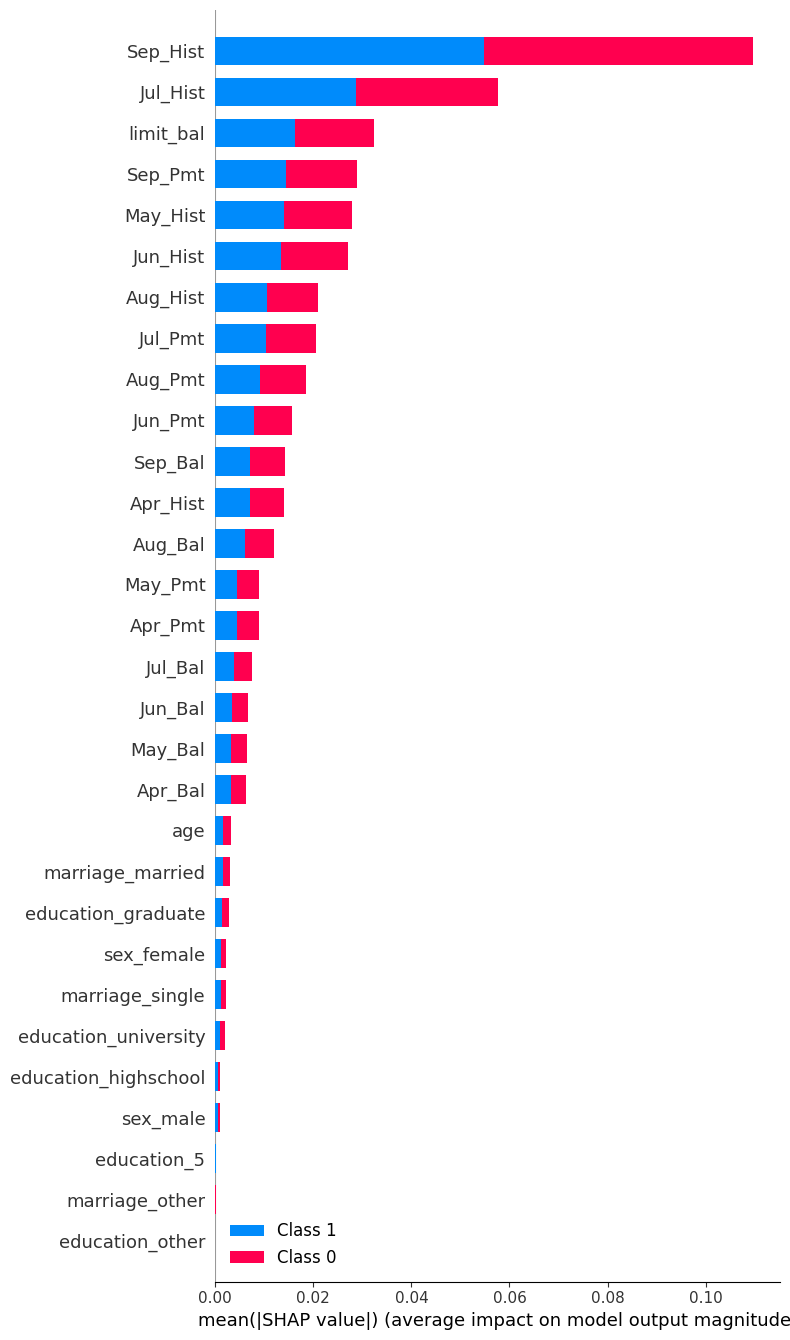

In [ ]:
shap.summary_plot(shap_values, X_test, max_display=X_test.shape[1])

## Dependence plots - global interpretability

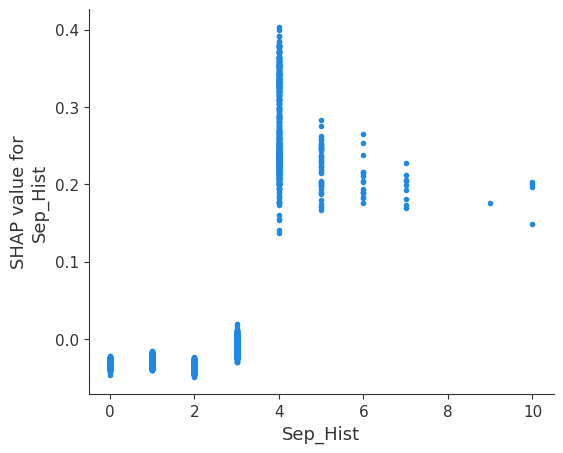

In [ ]:
shap.dependence_plot("Sep_Hist", shap_values[1], X_test, interaction_index=None)

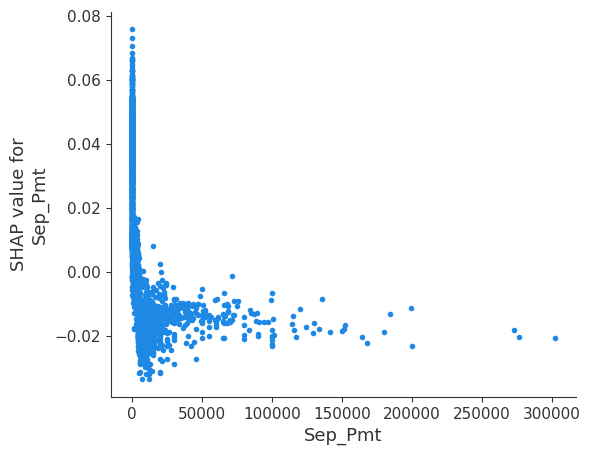

In [ ]:
shap.dependence_plot("Sep_Pmt", shap_values[1], X_test, interaction_index=None)

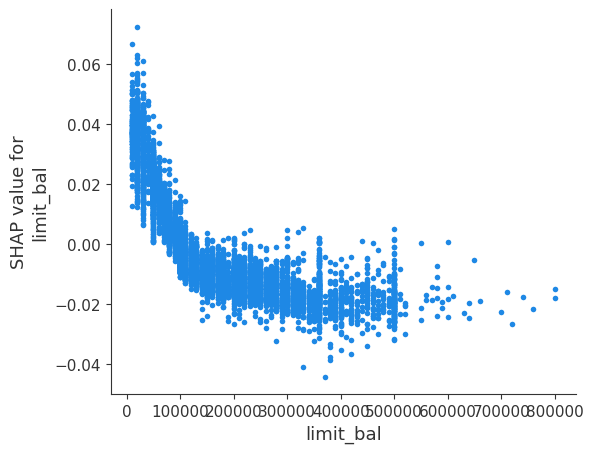

In [ ]:
shap.dependence_plot("limit_bal", shap_values[1], X_test, interaction_index=None)

## Shap value plot - local interpretability

### Identify misclassified clients

In [ ]:
fp = []
fn = []
for index, actual, predicted in zip(range(X_test.shape[0]), y_test.values, y_pred):
  if actual == 0 and predicted == 1:
    fp.append(index)
  if actual == 1 and predicted == 0:
    fn.append(index)

### See some explanations for misclassified clients

In [ ]:
idx = fp[0]
shap.initjs()
print('Actual:', "Default" if y_test.values[idx] else "Did not default")
print('Predicted:', "Default" if y_pred[idx] else "Did not default")

vals = shap_values[1][idx,:]
positive_weight = defaultdict(float)
negative_weight = defaultdict(float)
feats = X_test.columns

for feat_i, val_i in zip(feats, vals):
  if val_i > 0:
    positive_weight[feat_i] += val_i
  elif val_i < 0:
    negative_weight[feat_i] += val_i
print(list(sorted(positive_weight.items(), key=operator.itemgetter(1), reverse=True))[:5])
print(list(sorted(negative_weight.items(), key=operator.itemgetter(1)))[:5])

shap.force_plot(
    explainer.expected_value[1], shap_values[1][idx,:], X_test.values[idx,:],
    feature_names=feats
)

Actual: Did not default
Predicted: Default
[('Sep_Hist', 0.22417293569385946), ('Jul_Hist', 0.08422275424249165), ('May_Hist', 0.05449187749439943), ('Jun_Hist', 0.03884353226964777), ('Apr_Hist', 0.03654787467641199)]
[('Jun_Pmt', -0.003449029246169175), ('age', -0.002437218527991263), ('Jul_Pmt', -0.0017157188414603298), ('May_Bal', -0.001292451916990558), ('Sep_Bal', -0.0007816413033151548)]


In [ ]:
idx = fp[1]
shap.initjs()
print('Actual:', "Default" if y_test.values[idx] else "Did not default")
print('Predicted:', "Default" if y_pred[idx] else "Did not default")

vals = shap_values[1][idx,:]
positive_weight = defaultdict(float)
negative_weight = defaultdict(float)
feats = X_test.columns

for feat_i, val_i in zip(feats, vals):
  if val_i > 0:
    positive_weight[feat_i] += val_i
  elif val_i < 0:
    negative_weight[feat_i] += val_i
print(list(sorted(positive_weight.items(), key=operator.itemgetter(1), reverse=True))[:5])
print(list(sorted(negative_weight.items(), key=operator.itemgetter(1)))[:5])

shap.force_plot(
    explainer.expected_value[1], shap_values[1][idx,:], X_test.values[idx,:],
    feature_names=feats
)

Actual: Did not default
Predicted: Default
[('Sep_Hist', 0.19035300828963955), ('Jul_Hist', 0.044297416331819474), ('Jun_Hist', 0.034880261739854174), ('May_Hist', 0.027345205224994517), ('Apr_Hist', 0.021578001383488754)]
[('Apr_Pmt', -0.010199972417144636), ('marriage_married', -0.006508388438624025), ('Sep_Bal', -0.004659480784152947), ('marriage_single', -0.004440083586973742), ('education_graduate', -0.0042137833898641475)]


In [ ]:
idx = fn[0]
shap.initjs()
print('Actual:', "Default" if y_test.values[idx] else "Did not default")
print('Predicted:', "Default" if y_pred[idx] else "Did not default")

vals = shap_values[1][idx,:]
positive_weight = defaultdict(float)
negative_weight = defaultdict(float)
feats = X_test.columns

for feat_i, val_i in zip(feats, vals):
  if val_i > 0:
    positive_weight[feat_i] += val_i
  elif val_i < 0:
    negative_weight[feat_i] += val_i
print(list(sorted(positive_weight.items(), key=operator.itemgetter(1), reverse=True))[:5])
print(list(sorted(negative_weight.items(), key=operator.itemgetter(1)))[:5])

shap.force_plot(
    explainer.expected_value[1], shap_values[1][idx,:], X_test.values[idx,:],
    feature_names=feats
)

Actual: Default
Predicted: Did not default
[('Aug_Hist', 0.049682183703116604), ('limit_bal', 0.022771459465202495), ('education_graduate', 0.0034239000371235305), ('education_university', 0.0008077558726199641), ('sex_male', 0.00015270805199179448)]
[('Sep_Hist', -0.03791123971317575), ('Jul_Hist', -0.017808040292311488), ('Jul_Pmt', -0.007095376530387511), ('Aug_Bal', -0.006801784235703962), ('May_Hist', -0.006397384026086001)]


In [ ]:
idx = fn[3]
shap.initjs()
print('Actual:', "Default" if y_test.values[idx] else "Did not default")
print('Predicted:', "Default" if y_pred[idx] else "Did not default")

vals = shap_values[1][idx,:]
positive_weight = defaultdict(float)
negative_weight = defaultdict(float)
feats = X_test.columns

for feat_i, val_i in zip(feats, vals):
  if val_i > 0:
    positive_weight[feat_i] += val_i
  elif val_i < 0:
    negative_weight[feat_i] += val_i
print(list(sorted(positive_weight.items(), key=operator.itemgetter(1), reverse=True))[:5])
print(list(sorted(negative_weight.items(), key=operator.itemgetter(1)))[:5])

shap.force_plot(
    explainer.expected_value[1], shap_values[1][idx,:], X_test.values[idx,:],
    feature_names=feats
)

Actual: Default
Predicted: Did not default
[('education_graduate', 0.002067580002867544), ('May_Pmt', 0.0014745314233095997), ('age', 0.0007061348826300673), ('education_university', 0.0006690214352693146), ('education_highschool', 5.010122075873369e-05)]
[('Sep_Hist', -0.03643162959786423), ('Jul_Hist', -0.01621070907705871), ('limit_bal', -0.014241627587562106), ('Jul_Pmt', -0.011762346835541847), ('Jun_Pmt', -0.009325135332665014)]


## Identify reasons for misclassification

### Calculate count and weight of features that contribute to misclassification

In [ ]:
# Identify tokens that contributed to the misclassification of clients
positive_weight = defaultdict(float)
negative_weight = defaultdict(float)
positive_count = defaultdict(int)
negative_count = defaultdict(int)
for idx in range(y_test.shape[0]):
  if y_test.values[idx] == 0 and y_pred[idx] == 1:
    # Misclassified as 1, identify all features that contributed to positive prediction
    vals = shap_values[1][idx,:]
    feats = X_test.columns

    for feat_i, val_i in zip(feats, vals):
      if val_i > 0:
        positive_weight[feat_i] += abs(val_i)
        positive_count[feat_i] += 1
  elif y_test.values[idx] == 1 and y_pred[idx] == 0:
    # Misclassified as 0, identify all features that contributed to negative prediction
    vals = shap_values[1][idx,:]
    feats = X_test.columns

    for feat_i, val_i in zip(feats, vals):
      if val_i < 0:
        negative_weight[feat_i] += abs(val_i)
        negative_count[feat_i] += 1

In [ ]:
positive_average_weight = {feature:(positive_weight[feature] / positive_count[feature]) for feature in positive_weight}
negative_average_weight = {feature:(negative_weight[feature] / negative_count[feature]) for feature in negative_weight}

### Plots for misclassification statistics

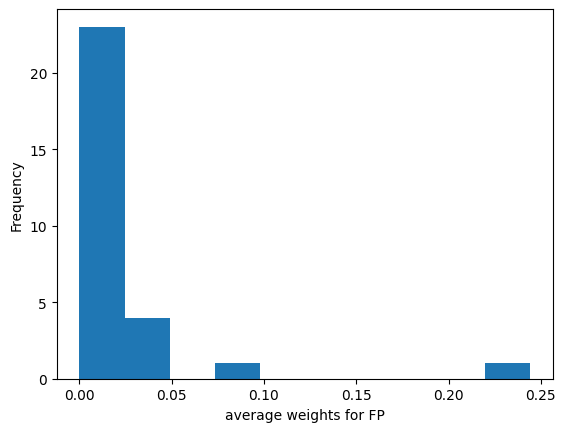

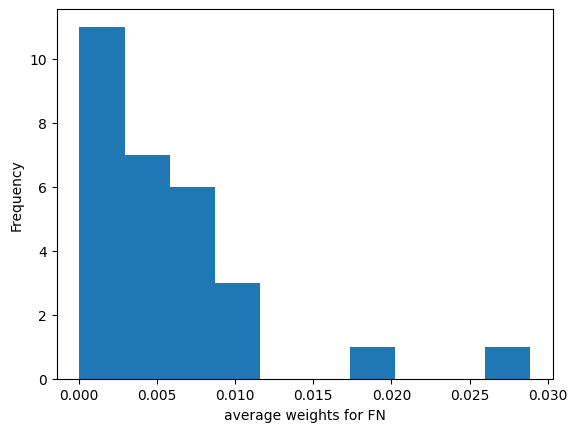

In [ ]:
plt.hist(positive_average_weight.values())
plt.xlabel('average weights for FP')
plt.ylabel('Frequency')
plt.show()
plt.hist(negative_average_weight.values())
plt.xlabel('average weights for FN')
plt.ylabel('Frequency')
plt.show()

## Performance metrics for model

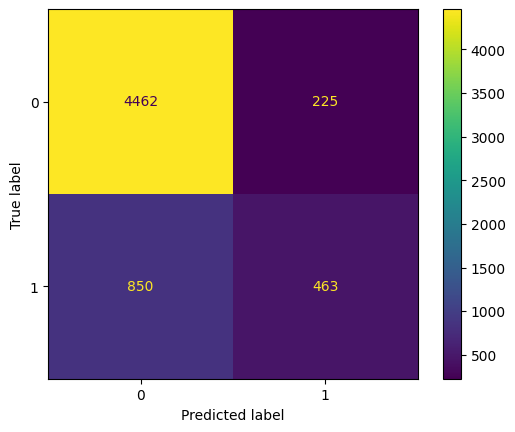

In [ ]:
matrix = metrics.confusion_matrix(y_true=y_test, y_pred=y_pred)
display = metrics.ConfusionMatrixDisplay(confusion_matrix=matrix)
display.plot()

In [ ]:
# Compute the accuracy of the classifier and the number of misclassified clients
print(f'Accuracy: {(matrix[0, 0] + matrix[1, 1]) / matrix.sum()}')
print(f'Number of misclassified clients: {matrix[0, 1] + matrix[1, 0]}')

Accuracy: 0.8208333333333333
Number of misclassified clients: 1075


## Propose an improved model (dropping features with the most misclassification average weight)

### Select features to remove from the original model

In [ ]:
bad_features_positive = [k for k, v in positive_average_weight.items() if v > 0.1]
bad_features_negative = [k for k, v in negative_average_weight.items() if v > 0.015]
bad_features = set(bad_features_positive + bad_features_negative)
print(f'Removing {len(bad_features)} features: {bad_features}')

Removing 2 features: {'Sep_Hist', 'Jul_Hist'}


### Train the classifier on the modified feature set

In [ ]:
X_train_modified = X_train.drop(columns=bad_features, inplace=False)
X_test_modified = X_test.drop(columns=bad_features, inplace=False)

In [ ]:
clf_modified = RandomForestClassifier(**best_params_)
clf_modified.fit(X_train_modified, y_train)

RandomForestClassifier(bootstrap=False, max_depth=10, min_samples_leaf=2,
                       min_samples_split=10, n_estimators=50)

### Evaluate the modified classifier

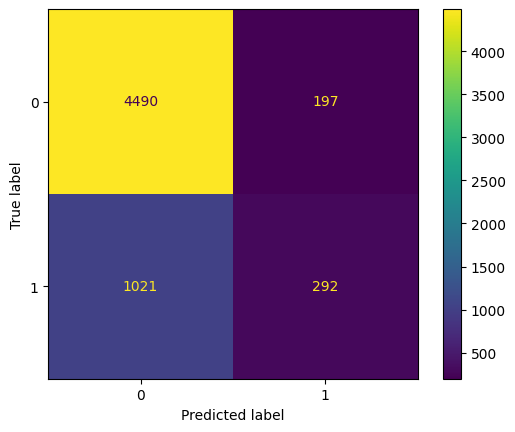

In [ ]:
y_pred_modified = clf_modified.predict(X_test_modified)
matrix_modified = metrics.confusion_matrix(y_true=y_test, y_pred=y_pred_modified)
display = metrics.ConfusionMatrixDisplay(confusion_matrix=matrix_modified)
display.plot()

In [ ]:
# Compute the accuracy of the classifier and the number of misclassified clients
print(f'Accuracy: {(matrix_modified[0, 0] + matrix_modified[1, 1]) / matrix_modified.sum()}')
print(f'Number of misclassified clients: {matrix_modified[0, 1] + matrix_modified[1, 0]}')

Accuracy: 0.797
Number of misclassified clients: 1218


## Propose an improved model (dropping the least predictive features)

### Select features to remove from the original model

In [ ]:
importance_vals = np.abs(shap_values[1]).mean(0)
feature_importance = pd.DataFrame(list(zip(X_train.columns, importance_vals)), columns=['col_name', 'feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'], ascending=False, inplace=True)
bad_features = feature_importance.tail(5)['col_name'].values
print(f'Removing {len(bad_features)} features: {bad_features}')

Removing 5 features: ['education_highschool' 'sex_male' 'education_5' 'marriage_other'
 'education_other']


### Train the classifier on the modified feature set

In [ ]:
X_train_modified = X_train.drop(columns=bad_features, inplace=False)
X_test_modified = X_test.drop(columns=bad_features, inplace=False)

In [ ]:
clf_modified = RandomForestClassifier(**best_params_)
clf_modified.fit(X_train_modified, y_train)

RandomForestClassifier(bootstrap=False, max_depth=10, min_samples_leaf=2,
                       min_samples_split=10, n_estimators=50)

### Evaluate the modified classifier

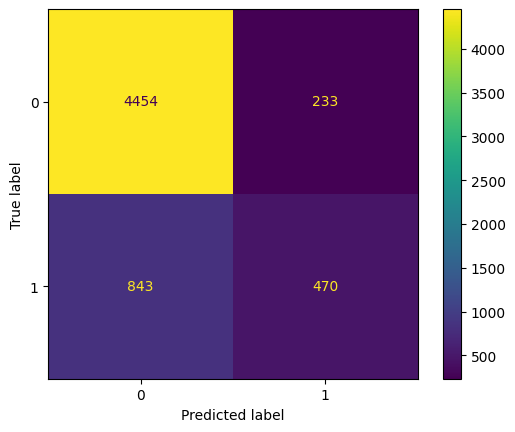

In [ ]:
y_pred_modified = clf_modified.predict(X_test_modified)
matrix_modified = metrics.confusion_matrix(y_true=y_test, y_pred=y_pred_modified)
display = metrics.ConfusionMatrixDisplay(confusion_matrix=matrix_modified)
display.plot()

In [ ]:
# Compute the accuracy of the classifier and the number of misclassified clients
print(f'Accuracy: {(matrix_modified[0, 0] + matrix_modified[1, 1]) / matrix_modified.sum()}')
print(f'Number of misclassified clients: {matrix_modified[0, 1] + matrix_modified[1, 0]}')

Accuracy: 0.8206666666666667
Number of misclassified clients: 1076
